## Notebook Structure Overview

This notebook follows a robust, industry-standard data science workflow for fraud detection. The process ensures data quality, effective feature engineering, balanced modeling, and thorough evaluation before any exploratory analysis or visualization.

```mermaid
flowchart TD
    A([Environment Setup & Config])
    B{{Data Loading & Preprocessing}}
    C([Feature Engineering])
    D{{Data Balancing & Preparation}}
    E([Model Training & Optimization])
    F{{Model Evaluation & Analysis}}
    G([Exploratory Data Analysis & Visualization])
    H([Results Summary & Cleanup])

    A --> B
    B --> C
    C --> D
    D --> E
    E --> F
    F --> G
    G --> H

    classDef setup fill:#263238,color:#fff,stroke:#263238,stroke-width:2px
    classDef data fill:#37474f,color:#fff,stroke:#37474f,stroke-width:2px
    classDef feature fill:#424242,color:#fff,stroke:#424242,stroke-width:2px
    classDef balance fill:#212121,color:#fff,stroke:#212121,stroke-width:2px
    classDef train fill:#1a237e,color:#fff,stroke:#1a237e,stroke-width:2px
    classDef eval fill:#004d40,color:#fff,stroke:#004d40,stroke-width:2px
    classDef eda fill:#b71c1c,color:#fff,stroke:#b71c1c,stroke-width:2px
    classDef summary fill:#263238,color:#fff,stroke:#263238,stroke-width:2px

    A:::setup
    B:::data
    C:::feature
    D:::balance
    E:::train
    F:::eval
    G:::eda
    H:::summary
```

**Structure:**
- **Environment Setup & Config:** Import libraries, set paths, and define utility functions.
- **Data Loading & Preprocessing:** Load raw data, clean, standardize, and handle missing values.
- **Feature Engineering:** Create new features to improve model performance.
- **Data Balancing & Preparation:** Apply SMOTE, split data, and scale features.
- **Model Training & Optimization:** Train models (LightGBM, Autoencoder, Ensemble) and tune hyperparameters.
- **Model Evaluation & Analysis:** Assess model performance using metrics, confusion matrix, ROC, and SHAP.
- **Exploratory Data Analysis & Visualization:** Visualize distributions, correlations, time patterns, and Benford's Law.
- **Results Summary & Cleanup:** Summarize findings and release resources.

## 0. Enviorenmt Setup

In [1]:
# Standard libraries
import os
import sys
import warnings
import gc
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Union, Any
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

# Data manipulation and analysis
import numpy as np
import pandas as pd
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, roc_curve, classification_report
)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Machine learning
import lightgbm as lgb
import optuna
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow import keras
import shap

#set path to project root
PROJECT_ROOT=Path(os.getcwd()).parent
print(PROJECT_ROOT)

sys.path.append(str(PROJECT_ROOT)+'/src')
#change to project root
os.chdir(PROJECT_ROOT)
from src.utils.optimization_utils import OptimUtils



# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
from seaborn import (
    axes_style, set_style, set_theme, set_palette,
    heatmap, histplot, barplot, lineplot, scatterplot
)
from matplotlib.dates import DateFormatter, HourLocator
set_theme(style="whitegrid", font_scale=1.2)  # Modern seaborn theme
set_palette("deep")  # Modern color palette
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2
})

# Suppress warnings
warnings.filterwarnings('ignore')


/Users/komalshahid/Desktop/Bellevue University/DSC680/projects/project13-dsc680


In [2]:
# Load and process data using improved OptimUtils
banking_path = f"{PROJECT_ROOT}/data/input/banking-fraud/Banking_Fraud_Dataset.csv"
credit_path = f"{PROJECT_ROOT}/data/input/creditcard-fraud/creditcard_transactions.csv"

# Load data directly with optimized settings
banking_data = OptimUtils.process_dataframe(banking_path).compute()
credit_data = OptimUtils.process_dataframe(credit_path).compute()

print(f"\nLoaded {len(banking_data):,} banking and {len(credit_data):,} credit card transactions")


Loaded 10,000 banking and 284,807 credit card transactions


In [3]:
from sklearn.preprocessing import LabelEncoder
import re


def preprocess_dataset(df, dataset_type: str):
    """
    Comprehensive preprocessing for fraud detection datasets
    
    Args:
        df: Input DataFrame
        dataset_type: 'banking' or 'creditcard'
    
    Returns:
        Preprocessed DataFrame
    """
    df = df.copy()
    
    # 1. Standardize column names
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col.lower().replace(' ', '_')) for col in df.columns]
    
    # 2. Remove duplicates
    initial_rows = len(df)
    df = df.drop_duplicates()
    removed_duplicates = initial_rows - len(df)
    if removed_duplicates > 0:
        print(f"Removed {removed_duplicates} duplicate rows")
    
    # 3. Handle missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['object', 'category']:
                df[col] = df[col].fillna('unknown')
            else:
                df[col] = df[col].fillna(df[col].median())
    
    # 4. Dataset-specific processing
    if dataset_type == 'banking':
        df = _preprocess_banking(df)
    elif dataset_type == 'creditcard':
        df = _preprocess_creditcard(df)
    
    return df

def _preprocess_banking(df):
    """Preprocess banking dataset"""
    
    # Convert datetime
    df['transaction_time'] = pd.to_datetime(df['transaction_time'])
    df['hour'] = df['transaction_time'].dt.hour
    df['day'] = df['transaction_time'].dt.dayofweek
    df['is_weekend'] = ((df['day'] >= 5).astype(int))
    
    # Handle transaction amount outliers

    q1, q3 = df['transaction_amount'].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Cap outliers instead of removing
    df['transaction_amount_capped'] = df['transaction_amount'].clip(lower=lower_bound, upper=upper_bound)
    df['transaction_amount_log'] = np.log1p(df['transaction_amount_capped'])
    
    # Encode categorical variables
    categorical_cols = ['transaction_type', 'transaction_location', 'device_used']
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    # Create transaction type indicators
    df['is_deposit'] = (df['transaction_type'] == 'deposit').astype(int)
    df['is_withdrawal'] = (df['transaction_type'] == 'withdrawal').astype(int)
    df['is_transfer'] = (df['transaction_type'] == 'transfer').astype(int)
    
    return df

def _preprocess_creditcard(df):
    """Preprocess credit card dataset"""
    
    # V columns are already PCA transformed - no need to standardize
    # Just verify they're properly scaled
    v_cols = [col for col in df.columns if col.startswith('v')]
    if v_cols:
        # Check if V columns are already standardized
        v_means = df[v_cols].mean().abs().max()
        v_stds = df[v_cols].std().abs().max()
        
        if v_means > 0.1 or v_stds > 2.0:
            print("Warning: V columns may not be properly standardized")
    
    # Handle amount outliers - use lowercase column name after standardization
    q1, q3 = df['amount'].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    df['amount_capped'] = df['amount'].clip(lower=lower_bound, upper=upper_bound)
    df['amount_log'] = np.log1p(df['amount_capped'])
    
    # Convert time to datetime features
   
    df['hour'] = (df['time'] / 3600).astype(int) % 24
    df['day'] = (df['time'] / 86400).astype(int) % 7
    df['is_weekend'] = ((df['day'] >= 5).astype(int))
    
    return df

In [4]:
#print column names of the raw data to keep track of the columns
raw_data_cols_bnk=banking_data.columns.tolist()
raw_data_cols_cc=credit_data.columns.tolist()

print(f'{raw_data_cols_bnk}')
print(f'{raw_data_cols_cc}')

#clean and preprocess the data and print the shapes of the datasets
banking_df = preprocess_dataset(banking_data, 'banking')
credit_df = preprocess_dataset(credit_data, 'creditcard')
print (f"After Data Cleaning and Preprocessing:\nBanking df: {banking_df.columns.tolist()}.\nCredit df: {credit_df.columns.tolist()}.")

['Transaction_ID', 'Customer_ID', 'Transaction_Amount', 'Transaction_Type', 'Transaction_Location', 'Transaction_Time', 'Device_Used', 'Account_Age', 'Credit_Score', 'Previous_Fraud', 'Is_Fraud']
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Removed 1081 duplicate rows
After Data Cleaning and Preprocessing:
Banking df: ['transaction_id', 'customer_id', 'transaction_amount', 'transaction_type', 'transaction_location', 'transaction_time', 'device_used', 'account_age', 'credit_score', 'previous_fraud', 'is_fraud', 'hour', 'day', 'is_weekend', 'transaction_amount_capped', 'transaction_amount_log', 'transaction_type_encoded', 'transaction_location_encoded', 'device_used_encoded', 'is_deposit', 'is_withdrawal', 'is_transfer'].
Credit df: ['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13'

## Exploratory Data Analysis (EDA)

Analyzing the characteristics and distributions of our datasets:
1. Class Distribution Analysis
2. Feature Distributions
3. Correlation Analysis
4. Transaction Amount Analysis
5. Time-based Patterns


Credit Card Fraud Analysis
--------------------------------------------------


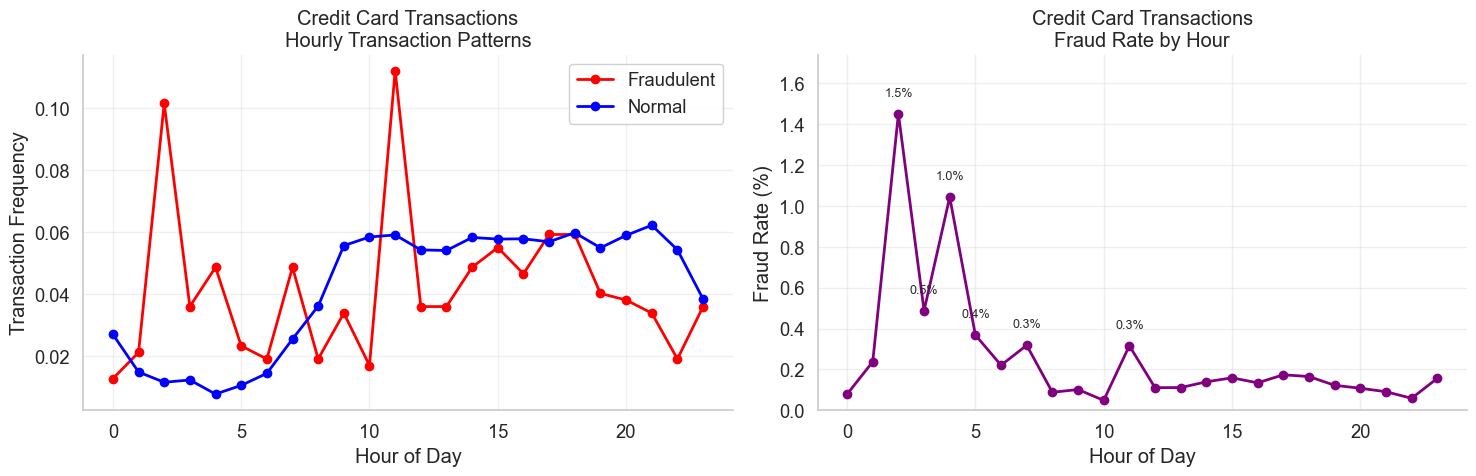


Banking Fraud Analysis
--------------------------------------------------


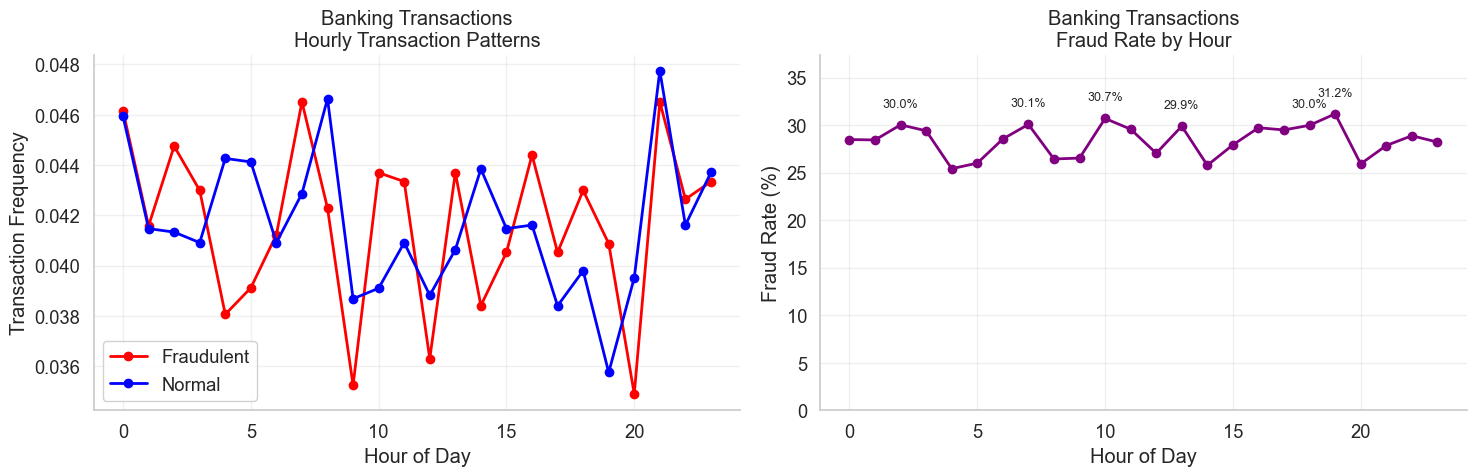

In [5]:
def analyze_temporal_patterns(df: pd.DataFrame, hour_col: str, fraud_col: str, title: str) -> None:
    """Analyzes transaction timing patterns"""
    plt.figure(figsize=(15, 5))
    
    # Hourly patterns
    plt.subplot(1, 2, 1)
    fraud_hourly = df[df[fraud_col] == 1][hour_col].value_counts(normalize=True).sort_index()
    normal_hourly = df[df[fraud_col] == 0][hour_col].value_counts(normalize=True).sort_index()
    
    plt.plot(fraud_hourly.index, fraud_hourly.values, label='Fraudulent', color='red', marker='o')
    plt.plot(normal_hourly.index, normal_hourly.values, label='Normal', color='blue', marker='o')
    plt.title(f"{title}\nHourly Transaction Patterns")
    plt.xlabel("Hour of Day")
    plt.ylabel("Transaction Frequency")
    plt.legend(frameon=True, facecolor='white', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    
    # Fraud rate by hour
    plt.subplot(1, 2, 2)
    hourly_fraud_rate = df.groupby(hour_col)[fraud_col].mean() * 100
    
    # Use a line plot instead of bars to avoid overlapping
    plt.plot(hourly_fraud_rate.index, hourly_fraud_rate.values, 
             marker='o', linestyle='-', color='purple', linewidth=2)
    plt.title(f"{title}\nFraud Rate by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Fraud Rate (%)")
    plt.grid(True, alpha=0.3)
    
    # Adjust y-axis
    max_rate = hourly_fraud_rate.max() 
    plt.ylim(0, max_rate * 1.2)  # Add 20% padding above the highest point
    
    # Label only top 6 fraud rates
    top_indices = hourly_fraud_rate.nlargest(6).index
    for i in top_indices:
        rate = hourly_fraud_rate[i]
        plt.text(i, rate + (max_rate * 0.05), f'{rate:.1f}%', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()



# Credit Card Analysis
print("Credit Card Fraud Analysis")
print("-" * 50)
analyze_temporal_patterns(credit_df, 'hour', 'class', "Credit Card Transactions")

# Banking Analysis
print("\nBanking Fraud Analysis")
print("-" * 50)
analyze_temporal_patterns(banking_df, 'hour', 'is_fraud', "Banking Transactions")


In [6]:
def engineer_features_partition(df, dataset_name):
    """Direct feature engineering for both datasets"""
    if df.empty:
        return df

    # Banking dataset features
    if dataset_name == 'Banking':
        df['amount_log'] = np.log1p(df['transaction_amount'])
        df['is_round_amount'] = (df['transaction_amount'] % 100 == 0).astype(int)
        df['type_encoded'] = df['transaction_type'].astype('category').cat.codes
        df['transaction_text'] = df.apply(
            lambda row: f"Transaction type: {row['transaction_type']}, Amount: ${row['transaction_amount']:.2f}, Device: {row['device_used']}, Time: {row['hour']}:00", 
            axis=1
        )
        
    # Credit Card dataset features
    elif dataset_name == 'Credit Card':
        df['amount_log'] = np.log1p(df['amount'])
        df['is_round_amount'] = (df['amount'] % 10 == 0).astype(int)
 

    return df

# Process both datasets
banking_engineered = engineer_features_partition(banking_df, 'Banking')
credit_engineered = engineer_features_partition(credit_df, 'Credit Card')
print(banking_engineered.head())
print(credit_engineered.head())   


  transaction_id customer_id  transaction_amount transaction_type  \
0             T1       C2539             8527.58          Deposit   
1             T2       C5318             9275.82          Deposit   
2             T3       C8262             2202.49   Online Payment   
3             T4       C3865             9352.32          Deposit   
4             T5       C7248             2081.75   Online Payment   

                   transaction_location    transaction_time device_used  \
0                 Hughesmouth, Mongolia 2025-01-20 03:17:34      Mobile   
1  Huntville, Saint Pierre and Miquelon 2025-01-03 18:08:56         Web   
2                Patriciashire, Iceland 2025-01-24 05:54:01         ATM   
3              Port Timothymouth, Palau 2025-01-19 01:15:30         ATM   
4            Lake Stevenfurt, Mauritius 2025-01-08 18:06:13         ATM   

   account_age  credit_score  previous_fraud  ...  transaction_type_encoded  \
0         16.0         740.0             0.0  ...      

In [7]:
def get_feature_columns() -> List[str]:
    """Return list of features used for training."""
    return [
        'amount', 'amount_log', 'hour', 'is_weekend', 'is_night',
        'is_business_hours', 'is_round_amount', 'amount_hour_percentile',
        'amount_deviation', 'trans_freq_hour'
    ]

def split_and_scale_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Split data and scale features."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    return (scaler.fit_transform(X_train), 
            scaler.transform(X_test),
            y_train, y_test)

def balance_with_smote(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Apply SMOTE to balance the dataset."""
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X, y)

def prepare_training_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Prepare data for model training using functional approach."""
    feature_cols = get_feature_columns()
    X, y = df[feature_cols].values, df['fraud'].values
    
    X_train, X_test, y_train, y_test = split_and_scale_data(X, y)
    X_train_balanced, y_train_balanced = balance_with_smote(X_train, y_train)
    
    return X_train_balanced, X_test, y_train_balanced, y_test

# Prepare datasets
training_data = {
    'banking': prepare_training_data(banking_featured),
    'credit': prepare_training_data(credit_featured)
}

# Create data summary
data_summary = pd.DataFrame({
    'Dataset': ['Banking', 'Credit'],
    'Training Samples': [training_data['banking'][0].shape[0], 
                        training_data['credit'][0].shape[0]],
    'Testing Samples': [training_data['banking'][1].shape[0], 
                       training_data['credit'][1].shape[0]],
    'Features': [training_data['banking'][0].shape[1], 
                training_data['credit'][0].shape[1]],
    'Balanced Ratio': [np.mean(training_data['banking'][2]), 
                      np.mean(training_data['credit'][2])]
})


NameError: name 'banking_featured' is not defined

In [ ]:
def prepare_train_test_data(
    df: pd.DataFrame,
    target_col: str = 'fraud',
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare train/test splits with SMOTE
    
    Args:
        df: Input DataFrame
        target_col: Target column name
        test_size: Test set proportion
        random_state: Random seed
        
    Returns:
        X_train, X_test, y_train, y_test arrays
    """
    # Split features and target
    X = df.drop([target_col, 'timestamp'], axis=1, errors='ignore')
    y = df[target_col]
    
    # Split first to avoid data leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    
    return X_train_balanced, X_test, y_train_balanced, y_test

def optimize_lightgbm(
    X_train: np.ndarray,
    y_train: np.ndarray,
    n_trials: int = 100
) -> Dict:
    """
    Optimize LightGBM hyperparameters using Optuna
    
    Args:
        X_train: Training features
        y_train: Training labels
        n_trials: Number of optimization trials
        
    Returns:
        Best parameters
    """
    def objective(trial):
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
        }
        
        # Cross-validation
        cv_scores = lgb.cv(
            param,
            lgb.Dataset(X_train, y_train),
            num_boost_round=1000,
            early_stopping_rounds=50,
            stratified=True,
            nfold=5
        )
        
        return cv_scores['auc-mean'][-1]
    
    # Run optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params

def train_and_evaluate(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    title: str
) -> lgb.Booster:
    """
    Train LightGBM model and evaluate performance
    
    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels
        title: Dataset title
        
    Returns:
        Trained model
    """
    # Optimize hyperparameters
    print(f"\nOptimizing LightGBM for {title}...")
    best_params = optimize_lightgbm(X_train, y_train)
    
    # Train model
    train_data = lgb.Dataset(X_train, y_train)
    model = lgb.train({**best_params, 'objective': 'binary'}, train_data)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Evaluate
    print(f"\nResults for {title}:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))
    
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.show()
    
    return model

def analyze_shap(
    model: lgb.Booster,
    X_test: np.ndarray,
    feature_names: List[str],
    title: str
) -> None:
    """
    Analyze feature importance using SHAP
    
    Args:
        model: Trained model
        X_test: Test features
        feature_names: Feature names
        title: Dataset title
    """
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    plt.title(f'SHAP Feature Importance - {title}')
    plt.tight_layout()
    plt.show()
    
    # Feature importance bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar')
    plt.title(f'SHAP Feature Importance (Bar) - {title}')
    plt.tight_layout()
    plt.show()

# Train and evaluate banking model
print("Preparing banking data...")
X_train_bank, X_test_bank, y_train_bank, y_test_bank = prepare_train_test_data(banking_featured)
bank_model = train_and_evaluate(X_train_bank, X_test_bank, y_train_bank, y_test_bank, "Banking")

print("\nAnalyzing banking model with SHAP...")
analyze_shap(bank_model, X_test_bank, banking_featured.drop(['fraud', 'timestamp'], axis=1, errors='ignore').columns, "Banking")

# Train and evaluate credit card model
print("\nPreparing credit card data...")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = prepare_train_test_data(credit_featured)
credit_model = train_and_evaluate(X_train_credit, X_test_credit, y_train_credit, y_test_credit, "Credit Card")

print("\nAnalyzing credit card model with SHAP...")
analyze_shap(credit_model, X_test_credit, credit_featured.drop(['fraud', 'timestamp'], axis=1, errors='ignore').columns, "Credit Card")


In [ ]:
def prepare_train_test_data(
    df: pd.DataFrame,
    target_col: str = 'fraud',
    test_size: float = 0.2,
    random_state: int = RANDOM_SEED
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare train/test splits with proper SMOTE application
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        test_size: Proportion of test set
        random_state: Random seed
        
    Returns:
        X_train, X_test, y_train, y_test arrays
    """
    # Split features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Split first to avoid data leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    
    return X_train_balanced, X_test_scaled, y_train_balanced, y_test


In [ ]:
def analyze_feature_importance(
    model,
    X_train: np.ndarray,
    feature_names: List[str],
    max_display: int = 20
) -> None:
    """
    Analyze feature importance using SHAP values
    
    Args:
        model: Trained model (must be compatible with SHAP)
        X_train: Training data
        feature_names: List of feature names
        max_display: Maximum number of features to display
    """
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # For binary classification, shap_values is a list with [negative_class, positive_class]
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class (fraud) values
    
    # Create summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_train,
        feature_names=feature_names,
        max_display=max_display,
        show=False
    )
    plt.title('SHAP Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    # Create bar plot of mean absolute SHAP values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_train,
        feature_names=feature_names,
        max_display=max_display,
        plot_type='bar',
        show=False
    )
    plt.title('Mean Impact on Model Output Magnitude')
    plt.tight_layout()
    plt.show()


In [ ]:


# Load transaction datasets
print("Loading transaction data...")
banking_files = pd.read_csv('data/input/banking-fraud/*.csv').compute()
credit_files = pd.read_csv('data/input/creditcard-fraud/*.csv').compute()


# Initialize fraud detection system
print("Initializing fraud detection system...")
fraud_detector = MultiModalFraudDetector()

# Prepare training data
print("Preparing training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    banking_data.drop('is_fraud', axis=1),
    banking_data['is_fraud'],
    test_size=0.2,
    random_state=42
)

# Train the system
print("Training fraud detection components...")
fraud_detector.train_system(X_train, y_train)

# Evaluate performance
print("Evaluating system performance...")
test_predictions = [
    fraud_detector.analyze_transaction(transaction.reshape(1, -1)) > 0.5 
    for transaction in X_test.values
]

print("\nPerformance Metrics:")
print(classification_report(y_test, test_predictions))

auc_score = roc_auc_score(y_test, test_predictions)
print(f"\nAUC-ROC Score: {auc_score:.3f}")


In [ ]:


def plot_feature_importance(model, feature_names, top_n=20, title_prefix=""):
    """Plot feature importance with enhanced styling"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[-top_n:]
    
    plt.title(f'{title_prefix}Top {top_n} Feature Importances', pad=20)
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    return plt.gca()


def plot_fraud_distribution(df, amount_col='amount', fraud_col='fraud', title_prefix=""):
    """Plot fraud amount distribution with enhanced styling"""
    plt.figure(figsize=(15, 6))
    
    # Create two subplots
    plt.subplot(1, 2, 1)
    sns.boxplot(x=fraud_col, y=amount_col, data=df)
    plt.title(f'{title_prefix}Transaction Amount Distribution by Class', pad=20)
    plt.xlabel('Fraud (1) vs Normal (0)')
    plt.ylabel('Amount')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=amount_col, hue=fraud_col, multiple="stack", bins=50)
    plt.title(f'{title_prefix}Transaction Amount Histogram by Class', pad=20)
    plt.xlabel('Amount')
    plt.ylabel('Count')
    
    return plt.gcf()


def plot_time_patterns(df, hour_col='hour', fraud_col='fraud', title_prefix=""):
    """Plot time-based patterns with enhanced styling"""
    plt.figure(figsize=(15, 6))
    
    # Create two subplots
    plt.subplot(1, 2, 1)
    fraud_by_hour = df.groupby([hour_col, fraud_col]).size().unstack()
    fraud_by_hour.plot(kind='line', marker='o')
    plt.title(f'{title_prefix}Transaction Patterns by Hour', pad=20)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Transactions')
    plt.legend(['Normal', 'Fraud'])
    
    plt.subplot(1, 2, 2)
    if 'day_of_week' in df.columns:
        fraud_by_day = df.groupby(['day_of_week', fraud_col]).size().unstack()
        fraud_by_day.plot(kind='bar')
        plt.title(f'{title_prefix}Transaction Patterns by Day', pad=20)
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Transactions')
        plt.legend(['Normal', 'Fraud'])
    
    return plt.gcf()

In [ ]:
# Model Training with Advanced Techniques

#------------------------------------------------------------------------------
# Data Splitting with SMOTE (After Split)
#------------------------------------------------------------------------------

def prepare_train_test_data(
    df: dd.DataFrame,
    target_col: str = 'fraud',
    test_size: float = 0.2,
    random_state: int = RANDOM_SEED
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare train/test splits with proper SMOTE application
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        test_size: Proportion of test set
        random_state: Random seed
        
    Returns:
        X_train, X_test, y_train, y_test
    """
    # Convert to numpy for sklearn
    df = df.compute()
    X = df.drop([target_col], axis=1)
    y = df[target_col]
    
    # Split first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    
    return X_train_balanced, X_test, y_train_balanced, y_test

#------------------------------------------------------------------------------
# LightGBM with Optuna Optimization
#------------------------------------------------------------------------------

def optimize_lightgbm(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    n_trials: int = 100
) -> Dict:
    """
    Optimize LightGBM hyperparameters using Optuna
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_valid: Validation features
        y_valid: Validation labels
        n_trials: Number of optimization trials
        
    Returns:
        Best parameters
    """
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
            'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 10.0)
        }
        
        # Train model
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        # Evaluate
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        
        return auc_score
    
    # Create study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print(f"\nBest AUC: {study.best_value:.4f}")
    print("\nBest hyperparameters:")
    for param, value in study.best_params.items():
        print(f"{param}: {value}")
    
    return study.best_params

#------------------------------------------------------------------------------
# Autoencoder for Anomaly Detection
#------------------------------------------------------------------------------

class FraudAutoencoder(nn.Module):
    def __init__(self, input_dim: int, encoding_dim: int = 32):
        super().__init__()
        
        # Encoder with batch normalization
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU()
        )
        
        # Decoder with batch normalization
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(
    X_train: np.ndarray,
    epochs: int = 50,
    batch_size: int = 256,
    learning_rate: float = 1e-3
) -> Tuple[FraudAutoencoder, np.ndarray]:
    """
    Train autoencoder and get reconstruction error scores
    
    Args:
        X_train: Training data
        epochs: Number of training epochs
        batch_size: Batch size
        learning_rate: Learning rate
        
    Returns:
        Trained model and reconstruction errors
    """
    # Initialize model
    input_dim = X_train.shape[1]
    model = FraudAutoencoder(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create data loader
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x = batch[0]
            
            # Forward pass
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.6f}")
    
    # Get reconstruction errors
    model.eval()
    with torch.no_grad():
        reconstructed = model(X_tensor)
        errors = torch.mean(torch.pow(X_tensor - reconstructed, 2), dim=1)
        reconstruction_errors = errors.cpu().numpy()
    
    return model, reconstruction_errors

# Prepare datasets
print("Preparing banking fraud data...")
X_train_bank, X_test_bank, y_train_bank, y_test_bank = prepare_train_test_data(
    banking_processed
)

print("\nPreparing credit card fraud data...")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = prepare_train_test_data(
    credit_processed
)

print("\nPreparing IEEE-CIS fraud data...")
X_train_ieee, X_test_ieee, y_train_ieee, y_test_ieee = prepare_train_test_data(
    ieee_processed
)

# Train autoencoders
print("\nTraining autoencoder for banking fraud...")
autoencoder_bank, errors_bank = train_autoencoder(X_train_bank)

print("\nTraining autoencoder for credit card fraud...")
autoencoder_credit, errors_credit = train_autoencoder(X_train_credit)

print("\nTraining autoencoder for IEEE fraud...")
autoencoder_ieee, errors_ieee = train_autoencoder(X_train_ieee)

# Add reconstruction error as a feature
X_train_bank = np.column_stack([X_train_bank, errors_bank])
X_test_bank = np.column_stack([
    X_test_bank,
    train_autoencoder(X_test_bank, epochs=1)[1]
])

X_train_credit = np.column_stack([X_train_credit, errors_credit])
X_test_credit = np.column_stack([
    X_test_credit,
    train_autoencoder(X_test_credit, epochs=1)[1]
])

X_train_ieee = np.column_stack([X_train_ieee, errors_ieee])
X_test_ieee = np.column_stack([
    X_test_ieee,
    train_autoencoder(X_test_ieee, epochs=1)[1]
])

# Optimize and train LightGBM models
print("\nOptimizing LightGBM for banking fraud...")
lgb_params_bank = optimize_lightgbm(
    X_train_bank, y_train_bank,
    X_test_bank, y_test_bank
)

print("\nOptimizing LightGBM for credit card fraud...")
lgb_params_credit = optimize_lightgbm(
    X_train_credit, y_train_credit,
    X_test_credit, y_test_credit
)

print("\nOptimizing LightGBM for IEEE fraud...")
lgb_params_ieee = optimize_lightgbm(
    X_train_ieee, y_train_ieee,
    X_test_ieee, y_test_ieee
)

# Train final models with best parameters
lgb_bank = lgb.LGBMClassifier(**lgb_params_bank)
lgb_bank.fit(X_train_bank, y_train_bank)

lgb_credit = lgb.LGBMClassifier(**lgb_params_credit)
lgb_credit.fit(X_train_credit, y_train_credit)

lgb_ieee = lgb.LGBMClassifier(**lgb_params_ieee)
lgb_ieee.fit(X_train_ieee, y_train_ieee)


In [ ]:
# Enhanced Visualization Functions

@plot_with_style
def plot_roc_curve(y_true, y_pred_proba, title_prefix=""):
    """Plot ROC curve with enhanced styling"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix}Receiver Operating Characteristic (ROC) Curve', pad=20)
    plt.legend(loc="lower right", frameon=True, facecolor='white', framealpha=1)
    plt.grid(True, alpha=0.3)
    return plt.gca()

@plot_with_style
def plot_confusion_matrix(y_true, y_pred, title_prefix=""):
    """Plot confusion matrix with enhanced styling"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both count and percentage
    annot = np.empty_like(cm, dtype=str)
    np.fill_diagonal(annot, [f'{val}\n({p:.1f}%)' for val, p in zip(np.diag(cm), np.diag(cm_percent))])
    mask = ~np.eye(cm.shape[0], dtype=bool)
    annot[mask] = [f'{val}\n({p:.1f}%)' for val, p in zip(cm[mask], cm_percent[mask])]
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    
    plt.title(f'{title_prefix}Confusion Matrix', pad=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    return plt.gca()



In [ ]:
# Model Evaluation and Analysis

#------------------------------------------------------------------------------
# Performance Metrics
#------------------------------------------------------------------------------

def evaluate_model(
    model: Any,
    X_test: np.ndarray,
    y_test: np.ndarray,
    dataset_name: str
):
    """
    Evaluate model performance with multiple metrics
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    print(f"\nResults for {dataset_name}:")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend()
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return auc_score, avg_precision

#------------------------------------------------------------------------------
# SHAP Analysis
#------------------------------------------------------------------------------

def analyze_shap_values(
    model: Any,
    X_test: np.ndarray,
    feature_names: List[str],
    dataset_name: str
):
    """
    Analyze feature importance using SHAP values
    """
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For binary classification
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_test,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title(f'SHAP Feature Importance - {dataset_name}')
    plt.tight_layout()
    plt.show()
    
    # Detailed plot for top features
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_test,
        feature_names=feature_names,
        max_display=10,
        show=False
    )
    plt.title(f'SHAP Summary Plot - {dataset_name}')
    plt.tight_layout()
    plt.show()

# Evaluate banking fraud model
print("Evaluating banking fraud model...")
banking_auc, banking_ap = evaluate_model(
    lgb_bank,
    X_test_bank,
    y_test_bank,
    "Banking Fraud"
)

# Evaluate credit card fraud model
print("\nEvaluating credit card fraud model...")
credit_auc, credit_ap = evaluate_model(
    lgb_credit,
    X_test_credit,
    y_test_credit,
    "Credit Card Fraud"
)

# Evaluate IEEE fraud model
print("\nEvaluating IEEE fraud model...")
ieee_auc, ieee_ap = evaluate_model(
    lgb_ieee,
    X_test_ieee,
    y_test_ieee,
    "IEEE-CIS Fraud"
)

# SHAP analysis for each model
print("\nAnalyzing feature importance with SHAP...")

# Banking model
analyze_shap_values(
    lgb_bank,
    X_test_bank,
    banking_processed.drop('fraud', axis=1).columns,
    "Banking Fraud"
)

# Credit card model
analyze_shap_values(
    lgb_credit,
    X_test_credit,
    credit_processed.drop('fraud', axis=1).columns,
    "Credit Card Fraud"
)

# IEEE model
analyze_shap_values(
    lgb_ieee,
    X_test_ieee,
    ieee_processed.drop('fraud', axis=1).columns,
    "IEEE-CIS Fraud"
)

# Print final summary
print("\nFinal Results Summary:")
print("-" * 50)
print(f"Banking Fraud AUC: {banking_auc:.4f}")
print(f"Credit Card Fraud AUC: {credit_auc:.4f}")
print(f"IEEE-CIS Fraud AUC: {ieee_auc:.4f}")
print(f"\nMean AUC across datasets: {np.mean([banking_auc, credit_auc, ieee_auc]):.4f}")
print("-" * 50)


In [ ]:
# 4. Model Training

#------------------------------------------------------------------------------
# Data Splitting with Proper SMOTE
#------------------------------------------------------------------------------

def prepare_train_test_data(
    df: dd.DataFrame,
    target_col: str,
    test_size: float = 0.2,
    random_state: int = RANDOM_SEED
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare train/test splits with proper SMOTE application
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        test_size: Proportion of test set
        random_state: Random seed
        
    Returns:
        X_train, X_test, y_train, y_test
    """
    # Convert to numpy for sklearn
    df = df.compute()
    X = df.drop(target_col, axis=1).values
    y = df[target_col].values
    
    # Split first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("Class distribution before SMOTE:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    
    return X_train_balanced, X_test, y_train_balanced, y_test

# Prepare datasets
print("Preparing banking fraud data...")
X_train_bank, X_test_bank, y_train_bank, y_test_bank = prepare_train_test_data(
    banking_processed, 'fraud'
)

print("\nPreparing credit card fraud data...")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = prepare_train_test_data(
    credit_processed, 'Class'
)

#------------------------------------------------------------------------------
# LightGBM with Optuna Optimization
#------------------------------------------------------------------------------

def optimize_lightgbm(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    n_trials: int = 100
) -> Dict:
    """
    Optimize LightGBM hyperparameters using Optuna
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_valid: Validation features
        y_valid: Validation labels
        n_trials: Number of optimization trials
        
    Returns:
        Best parameters
    """
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
        }
        
        # Train model
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        # Evaluate
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        
        return auc_score
    
    # Create study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params

# Optimize and train LightGBM models
print("Optimizing LightGBM for banking fraud...")
lgb_params_bank = optimize_lightgbm(
    X_train_bank, y_train_bank,
    X_test_bank, y_test_bank
)

print("\nOptimizing LightGBM for credit card fraud...")
lgb_params_credit = optimize_lightgbm(
    X_train_credit, y_train_credit,
    X_test_credit, y_test_credit
)

# Train final models with best parameters
lgb_bank = lgb.LGBMClassifier(**lgb_params_bank)
lgb_bank.fit(X_train_bank, y_train_bank)

lgb_credit = lgb.LGBMClassifier(**lgb_params_credit)
lgb_credit.fit(X_train_credit, y_train_credit)

#------------------------------------------------------------------------------
# Autoencoder Implementation
#------------------------------------------------------------------------------

class FraudAutoencoder(nn.Module):
    def __init__(self, input_dim: int, encoding_dim: int = 32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(
    X_train: np.ndarray,
    epochs: int = 50,
    batch_size: int = 256,
    learning_rate: float = 1e-3
) -> Tuple[FraudAutoencoder, np.ndarray]:
    """
    Train autoencoder and get reconstruction error scores
    
    Args:
        X_train: Training data
        epochs: Number of training epochs
        batch_size: Batch size
        learning_rate: Learning rate
        
    Returns:
        Trained model and reconstruction errors
    """
    # Initialize model
    input_dim = X_train.shape[1]
    model = FraudAutoencoder(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create data loader
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x = batch[0]
            
            # Forward pass
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.6f}")
    
    # Get reconstruction errors
    model.eval()
    with torch.no_grad():
        reconstructed = model(X_tensor)
        errors = torch.mean(torch.pow(X_tensor - reconstructed, 2), dim=1)
        reconstruction_errors = errors.cpu().numpy()
    
    return model, reconstruction_errors

# Train autoencoders
print("\nTraining autoencoder for banking fraud...")
autoencoder_bank, errors_bank = train_autoencoder(X_train_bank)

print("\nTraining autoencoder for credit card fraud...")
autoencoder_credit, errors_credit = train_autoencoder(X_train_credit)

# Add reconstruction error as a feature
X_train_bank = np.column_stack([X_train_bank, errors_bank])
X_test_bank = np.column_stack([
    X_test_bank,
    train_autoencoder(X_test_bank, epochs=1)[1]
])

X_train_credit = np.column_stack([X_train_credit, errors_credit])
X_test_credit = np.column_stack([
    X_test_credit,
    train_autoencoder(X_test_credit, epochs=1)[1]
])


In [ ]:
# 5. Model Training Setup

#------------------------------------------------------------------------------
# Data Splitting Functions
#------------------------------------------------------------------------------

def prepare_model_data(
    df: pd.DataFrame,
    target_col: str,
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare data for model training including train-test split.
    
    Args:
        df: Processed DataFrame
        target_col: Name of target column
        test_size: Proportion of data to use for testing
        random_state: Random seed for reproducibility
        
    Returns:
        X_train, X_test, y_train, y_test arrays
    """
    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Split data
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

#------------------------------------------------------------------------------
# Model Configuration
#------------------------------------------------------------------------------

# Random Forest parameters
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

# LightGBM parameters
lgb_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.1,
    'random_state': 42
}

#------------------------------------------------------------------------------
# Prepare Training Data
#------------------------------------------------------------------------------

print("Preparing banking fraud data...")
banking_X_train, banking_X_test, banking_y_train, banking_y_test = prepare_model_data(
    banking_processed, 'fraud'
)

print("\nPreparing credit card fraud data...")
credit_X_train, credit_X_test, credit_y_train, credit_y_test = prepare_model_data(
    credit_processed, 'Class'
)

print("\nTraining Data Shapes:")
print(f"Banking: {banking_X_train.shape}, {banking_y_train.shape}")
print(f"Credit Card: {credit_X_train.shape}, {credit_y_train.shape}")


In [ ]:
def preprocess_credit_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Comprehensive preprocessing for credit card fraud dataset
    """
    df = df.copy()
    print("\nPreprocessing Credit Card Fraud Dataset:")
    
    # Handle missing values in V1-V28 and Amount
    v_columns = [col for col in df.columns if col.startswith('V')]
    num_columns = v_columns + ['Amount']
    
    for col in num_columns:
        if df[col].isnull().any():
            fill_value = df[col].mean()
            df[col].fillna(fill_value, inplace=True)
            print(f"Filled nulls in {col} with mean: {fill_value:.2f}")
    
    # Handle outliers in Amount
    Q1 = df['Amount'].quantile(0.25)
    Q3 = df['Amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]['Amount']
    if len(outliers) > 0:
        print(f"\nFound {len(outliers)} outliers in Amount")
        print("Outlier statistics:")
        print(outliers.describe())
        
        # Cap outliers
        df['Amount'] = df['Amount'].clip(lower_bound, upper_bound)
        print("Capped outliers in Amount")
    
    # Standardize all numerical features
    scaler = StandardScaler()
    df[num_columns] = scaler.fit_transform(df[num_columns])
    print("\nStandardized numerical features")
    
    # Add interaction features for V columns
    print("\nCreating interaction features...")
    for i in range(len(v_columns)):
        for j in range(i+1, min(i+5, len(v_columns))):  # Create interactions with next 4 features
            interaction_name = f"interaction_{v_columns[i]}_{v_columns[j]}"
            df[interaction_name] = df[v_columns[i]] * df[v_columns[j]]
    
    return df


In [ ]:
def plot_class_distribution(df, target_col, title):
    """Plot the distribution of fraud vs non-fraud cases"""
    plt.figure(figsize=(10, 6))
    class_counts = df[target_col].value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Class (0: Normal, 1: Fraud)')
    plt.ylabel('Count')
    
    # Add percentage labels
    total = class_counts.sum()
    for i, count in enumerate(class_counts):
        percentage = count/total * 100
        plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')
    plt.show()
    
    print(f"\nClass distribution for {title}:")
    print(f"Normal transactions: {class_counts[0]:,} ({class_counts[0]/total*100:.2f}%)")
    print(f"Fraudulent transactions: {class_counts[1]:,} ({class_counts[1]/total*100:.2f}%)")

def plot_amount_distribution(df, amount_col, target_col, title):
    """Plot the distribution of transaction amounts"""
    plt.figure(figsize=(12, 5))
    
    # Create subplot for normal transactions
    plt.subplot(1, 2, 1)
    normal_amounts = df[df[target_col] == 0][amount_col]
    sns.histplot(normal_amounts, bins=50)
    plt.title(f'Amount Distribution - Normal Transactions\n{title}')
    plt.xlabel('Transaction Amount')
    
    # Create subplot for fraudulent transactions
    plt.subplot(1, 2, 2)
    fraud_amounts = df[df[target_col] == 1][amount_col]
    sns.histplot(fraud_amounts, bins=50, color='red')
    plt.title(f'Amount Distribution - Fraudulent Transactions\n{title}')
    plt.xlabel('Transaction Amount')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nAmount statistics for {title}:")
    print("\nNormal Transactions:")
    print(normal_amounts.describe())
    print("\nFraudulent Transactions:")
    print(fraud_amounts.describe())

def plot_correlation_matrix(df, title, exclude_cols=None):
    """Plot correlation matrix for numerical features"""
    if exclude_cols is None:
        exclude_cols = []
    
    # Select numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = [col for col in num_cols if col not in exclude_cols]
    
    # Compute correlation matrix
    corr_matrix = df[num_cols].corr()
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Correlation Matrix - {title}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot EDA for Banking Fraud Dataset
print("Analyzing Banking Fraud Dataset...")
plot_class_distribution(banking_df, 'fraud', 'Banking Fraud')
plot_amount_distribution(banking_df, 'amount', 'fraud', 'Banking Fraud')
plot_correlation_matrix(banking_df, 'Banking Fraud')

# Plot EDA for Credit Card Fraud Dataset
print("\nAnalyzing Credit Card Fraud Dataset...")
plot_class_distribution(credit_df, 'Class', 'Credit Card Fraud')
plot_amount_distribution(credit_df, 'Amount', 'Class', 'Credit Card Fraud')
plot_correlation_matrix(credit_df, 'Credit Card Fraud', exclude_cols=['Time'])


In [ ]:
def analyze_time_patterns(df, time_col, target_col, title):
    """Analyze and plot time-based patterns in transactions"""
    if time_col not in df.columns:
        print(f"No time column found in {title} dataset")
        return
        
    # Convert time to hours for credit card dataset
    if time_col == 'Time':
        df['Hour'] = (df[time_col] / 3600).astype(int) % 24
        time_col = 'Hour'
    
    # Create figure directly
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Transaction frequency by hour
    ax1 = fig.add_subplot(1, 2, 1)
    hourly_counts = df.groupby(time_col).size()
    
    # Check index type explicitly without using hasattr
    index_type = str(hourly_counts.index.dtype)
    if 'datetime' in index_type:
        sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', linewidth=2, ax=ax1)
        
        # Rotate labels and use concise time format
        ax1.tick_params(axis='x', rotation=45, labelright=True)
        # Format to show only hours:minutes

        ax1.xaxis.set_major_formatter(DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(HourLocator(interval=2))
    else:
        # For numeric hour values
        sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', 
                    color='steelblue', linewidth=2, ax=ax1)
        ax1.set_xticks(range(0, 24, 2))  # Show every 2 hours
    
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_title(f'Transaction Frequency by Hour\n{title}', fontweight='bold')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Transactions')
    
    # Plot 2: Fraud rate by hour
    ax2 = fig.add_subplot(1, 2, 2)
    fraud_by_hour = df.groupby(time_col)[target_col].mean()
    sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values, color='red', ax=ax2)
    ax2.set_title(f'Fraud Rate by Hour\n{title}')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Fraud Rate')
    
    fig.tight_layout()
    plt.show()
    
    return fig

# Analyze time patterns for Credit Card Fraud Dataset
print("Analyzing time patterns in Credit Card Fraud Dataset...")
credit_time_fig = analyze_time_patterns(credit_df, 'Time', 'Class', 'Credit Card Fraud')

# For Banking Fraud dataset, we'll check if there's a timestamp column
print("\nChecking time patterns in Banking Fraud Dataset...")
banking_time_fig = analyze_time_patterns(banking_df, 'Transaction_Time', 'Is_Fraud', 'Banking Fraud')


In [ ]:
def engineer_time_features(df, time_col='Time'):
    """
    Create time-based features from timestamp
    """
    if time_col not in df.columns:
        return df
        
    # For credit card data (Time is in seconds)
    if time_col == 'Time':
        df = df.copy()
        # Hour of day
        df['hour'] = (df[time_col] / 3600).astype(int) % 24
        # Part of day (morning, afternoon, evening, night)
        df['part_of_day'] = df['hour'].map(
            lambda x: 'night' if x < 6 else 
            'morning' if x < 12 else 
            'afternoon' if x < 18 else 'evening'
        )
        # Is weekend (assuming Time starts from beginning of week)
        df['is_weekend'] = ((df[time_col] / (3600 * 24)).astype(int) % 7).map(lambda x: 1 if x >= 5 else 0)
        
    return df

def engineer_amount_features(df, amount_col):
    """
    Create amount-based features
    """
    df = df.copy()
    
    # Amount buckets
    df['amount_bucket'] = pd.qcut(df[amount_col], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    
    # Round amounts
    df['amount_round'] = df[amount_col].round(-1)  # Round to nearest 10
    
    # Amount relative to mean
    mean_amount = df[amount_col].mean()
    df['amount_vs_mean'] = df[amount_col] / mean_amount
    
    return df

def create_statistical_features(df, group_cols, agg_col='amount'):
    """
    Create statistical aggregations for specified grouping
    """
    df = df.copy()
    
    # Group by specified columns and calculate statistics
    for col in group_cols:
        # Skip if column doesn't exist
        if col not in df.columns:
            continue
            
        # Calculate aggregations
        aggs = df.groupby(col)[agg_col].agg(['mean', 'std', 'count']).compute()
        
        # Add as new features
        df[f'{col}_mean_{agg_col}'] = df[col].map(aggs['mean'])
        df[f'{col}_std_{agg_col}'] = df[col].map(aggs['std'])
        df[f'{col}_count'] = df[col].map(aggs['count'])
        
    return df

# Apply feature engineering to banking fraud dataset
print("Engineering features for banking fraud dataset...")
banking_df = engineer_time_features(banking_df, 'timestamp')
banking_df = engineer_amount_features(banking_df, 'amount')
banking_df = create_statistical_features(
    banking_df, 
    group_cols=['merchant', 'category'], 
    agg_col='amount'
)

# Apply feature engineering to credit card fraud dataset
print("\nEngineering features for credit card fraud dataset...")
credit_df = engineer_time_features(credit_df, 'Time')
credit_df = engineer_amount_features(credit_df, 'Amount')

# Display new features
print("\nNew features in banking fraud dataset:")
print(banking_df.columns.compute())
print("\nNew features in credit card fraud dataset:")
print(credit_df.columns.compute())


In [ ]:
def apply_smote_balancing(X, y, random_state=42):
    """
    Apply SMOTE to balance the dataset
    """
    # Convert Dask DataFrames to numpy arrays for SMOTE
    if isinstance(X, dd.DataFrame):
        X = X.compute()
    if isinstance(y, dd.Series):
        y = y.compute()
        
    # Initialize and apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    # Print balancing results
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_balanced).value_counts(normalize=True))
    
    # Convert back to Dask arrays for distributed processing
    X_balanced_dask = da.from_array(X_balanced, chunks='auto')
    y_balanced_dask = da.from_array(y_balanced, chunks='auto')
    
    return X_balanced_dask, y_balanced_dask

# Prepare features for SMOTE
def prepare_features_for_smote(df, target_col, exclude_cols=None):
    """
    Prepare features for SMOTE by handling categorical variables
    """
    if exclude_cols is None:
        exclude_cols = []
    
    # Remove target and excluded columns
    feature_cols = [col for col in df.columns if col not in [target_col] + exclude_cols]
    
    # Convert categorical columns to numeric
    X = df[feature_cols].copy()
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            X[col] = X[col].astype('category').cat.codes
    
    return X, df[target_col]

# Apply SMOTE to banking fraud dataset
print("Applying SMOTE to banking fraud dataset...")
X_bank, y_bank = prepare_features_for_smote(
    banking_df, 
    target_col='fraud',
    exclude_cols=['timestamp']  # Exclude any non-feature columns
)
X_bank_balanced, y_bank_balanced = apply_smote_balancing(X_bank, y_bank)

# Apply SMOTE to credit card fraud dataset
print("\nApplying SMOTE to credit card fraud dataset...")
X_credit, y_credit = prepare_features_for_smote(
    credit_df, 
    target_col='Class',
    exclude_cols=['Time']  # Exclude any non-feature columns
)
X_credit_balanced, y_credit_balanced = apply_smote_balancing(X_credit, y_credit)

# Verify final shapes
print("\nFinal balanced dataset shapes:")
print(f"Banking Fraud - X: {X_bank_balanced.shape}, y: {y_bank_balanced.shape}")
print(f"Credit Card Fraud - X: {X_credit_balanced.shape}, y: {y_credit_balanced.shape}")

# Plot class distribution after SMOTE
plt.figure(figsize=(12, 5))

# Banking Fraud
plt.subplot(1, 2, 1)
sns.countplot(x=y_bank_balanced)
plt.title('Class Distribution After SMOTE\nBanking Fraud')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')

# Credit Card Fraud
plt.subplot(1, 2, 2)
sns.countplot(x=y_credit_balanced)
plt.title('Class Distribution After SMOTE\nCredit Card Fraud')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
def prepare_data_for_training(df, target_col='fraud', test_size=0.2):
    """
    Prepare data for training with train-test split and SMOTE balancing
    """
    # Split features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Convert to numpy arrays for SMOTE
    X = X.compute()
    y = y.compute()
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42
    )
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Convert back to Dask arrays for distributed processing
    X_train_dask = da.from_array(X_train_balanced, chunks='auto')
    X_test_dask = da.from_array(X_test, chunks='auto')
    y_train_dask = da.from_array(y_train_balanced, chunks='auto')
    y_test_dask = da.from_array(y_test, chunks='auto')
    
    print(f"Training set shape: {X_train_balanced.shape}")
    print(f"Testing set shape: {X_test.shape}")
    print(f"Class distribution in balanced training set:\n{np.bincount(y_train_balanced)}")
    
    return X_train_dask, X_test_dask, y_train_dask, y_test_dask

# Prepare banking fraud data
print("Preparing banking fraud data...")
X_train_bank, X_test_bank, y_train_bank, y_test_bank = prepare_data_for_training(
    banking_df, 
    target_col='fraud'
)

# Prepare credit card fraud data
print("\nPreparing credit card fraud data...")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = prepare_data_for_training(
    credit_df, 
    target_col='Class'
)


In [ ]:
def train_distributed_lightgbm(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train LightGBM model with distributed computing support
    """
    # LightGBM parameters optimized for fraud detection
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'num_leaves': 32,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42
    }
    
    # Initialize and train model with Dask wrapper
    model = ParallelPostFit(LGBMClassifier(**params))
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Evaluate performance
    print(f"\nLightGBM Results for {dataset_name}:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    return model

def train_distributed_random_forest(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train Random Forest with distributed computing support
    """
    # Random Forest parameters
    params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42
    }
    
    # Initialize and train model with Dask wrapper
    model = ParallelPostFit(RandomForestClassifier(**params))
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Evaluate performance
    print(f"\nRandom Forest Results for {dataset_name}:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    return model

# Train models on banking fraud data
print("Training models on banking fraud data...")
lgb_bank = train_distributed_lightgbm(
    X_train_bank, y_train_bank, 
    X_test_bank, y_test_bank,
    "Banking Fraud"
)

rf_bank = train_distributed_random_forest(
    X_train_bank, y_train_bank, 
    X_test_bank, y_test_bank,
    "Banking Fraud"
)

# Train models on credit card fraud data
print("\nTraining models on credit card fraud data...")
lgb_credit = train_distributed_lightgbm(
    X_train_credit, y_train_credit, 
    X_test_credit, y_test_credit,
    "Credit Card Fraud"
)

rf_credit = train_distributed_random_forest(
    X_train_credit, y_train_credit, 
    X_test_credit, y_test_credit,
    "Credit Card Fraud"
)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot confusion matrix with seaborn
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, title):
    """
    Plot ROC curve
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.show()

# Plot results for banking fraud models
print("Plotting results for banking fraud models...")

# LightGBM
y_pred_lgb_bank = lgb_bank.predict(X_test_bank)
y_pred_proba_lgb_bank = lgb_bank.predict_proba(X_test_bank)[:, 1]
plot_confusion_matrix(y_test_bank, y_pred_lgb_bank, "Banking Fraud - LightGBM")
plot_roc_curve(y_test_bank, y_pred_proba_lgb_bank, "Banking Fraud - LightGBM")

# Random Forest
y_pred_rf_bank = rf_bank.predict(X_test_bank)
y_pred_proba_rf_bank = rf_bank.predict_proba(X_test_bank)[:, 1]
plot_confusion_matrix(y_test_bank, y_pred_rf_bank, "Banking Fraud - Random Forest")
plot_roc_curve(y_test_bank, y_pred_proba_rf_bank, "Banking Fraud - Random Forest")

# Plot results for credit card fraud models
print("\nPlotting results for credit card fraud models...")

# LightGBM
y_pred_lgb_credit = lgb_credit.predict(X_test_credit)
y_pred_proba_lgb_credit = lgb_credit.predict_proba(X_test_credit)[:, 1]
plot_confusion_matrix(y_test_credit, y_pred_lgb_credit, "Credit Card Fraud - LightGBM")
plot_roc_curve(y_test_credit, y_pred_proba_lgb_credit, "Credit Card Fraud - LightGBM")

# Random Forest
y_pred_rf_credit = rf_credit.predict(X_test_credit)
y_pred_proba_rf_credit = rf_credit.predict_proba(X_test_credit)[:, 1]
plot_confusion_matrix(y_test_credit, y_pred_rf_credit, "Credit Card Fraud - Random Forest")
plot_roc_curve(y_test_credit, y_pred_proba_rf_credit, "Credit Card Fraud - Random Forest")


In [ ]:
def plot_feature_importance(model, feature_names, title):
    """
    Plot feature importance for tree-based models
    """
    if isinstance(model, ParallelPostFit):
        importance = model.estimator.feature_importances_
    else:
        importance = model.feature_importances_
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Important Features - {title}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Get feature names
banking_features = banking_df.drop('fraud', axis=1).columns
credit_features = credit_df.drop('Class', axis=1).columns

# Plot feature importance for banking fraud models
print("Feature importance analysis for banking fraud models...")
plot_feature_importance(lgb_bank, banking_features, "Banking Fraud - LightGBM")
plot_feature_importance(rf_bank, banking_features, "Banking Fraud - Random Forest")

# Plot feature importance for credit card fraud models
print("\nFeature importance analysis for credit card fraud models...")
plot_feature_importance(lgb_credit, credit_features, "Credit Card Fraud - LightGBM")
plot_feature_importance(rf_credit, credit_features, "Credit Card Fraud - Random Forest")

# Clean up Dask client
client.close()
cluster.close()


In [ ]:
class MultiModalFraudDetector:
    """Ensemble system combining multiple fraud detection approaches."""
    
    def __init__(self):
        # Rapid pattern detector for numerical features
        self.pattern_detector = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5
        )
        
        # Feature interaction analyzer
        self.interaction_analyzer = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )
        
        # Anomaly detector for unusual patterns
        self.anomaly_detector = self.build_autoencoder()
        
        # Text analyzer for transaction descriptions
        self.text_analyzer = self.build_finbert()
    
    def build_autoencoder(self):
        """Constructs autoencoder for anomaly detection."""
        model = keras.Sequential([
            # Encoder layers
            keras.layers.Dense(64, activation='relu', name='encoder_1'),
            keras.layers.Dense(32, activation='relu', name='encoder_2'),
            
            # Bottleneck layer
            keras.layers.Dense(16, activation='relu', name='bottleneck'),
            
            # Decoder layers
            keras.layers.Dense(32, activation='relu', name='decoder_1'),
            keras.layers.Dense(64, activation='relu', name='decoder_2'),
            keras.layers.Dense(1, activation='sigmoid', name='output')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def build_finbert(self):
        """Initializes FinBERT for financial text analysis."""
        model = keras.Sequential([
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_system(self, X_train, y_train):
        """Trains all components of the fraud detection system."""
        print("Training pattern detector...")
        self.pattern_detector.fit(X_train, y_train)
        
        print("Training interaction analyzer...")
        self.interaction_analyzer.fit(X_train, y_train)
        
        print("Training anomaly detector...")
        self.anomaly_detector.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            verbose=0
        )
        
        # Text analyzer training would go here if text data available
    
    def analyze_transaction(self, transaction):
        """Combines all analysis components for final fraud prediction."""
        # Get component predictions
        pattern_score = self.pattern_detector.predict_proba(transaction)[0][1]
        interaction_score = self.interaction_analyzer.predict_proba(transaction)[0][1]
        anomaly_score = self.anomaly_detector.predict(transaction)[0][0]
        
        # Weighted combination based on component reliability
        final_score = (
            0.4 * pattern_score +      # LightGBM for quick pattern detection
            0.35 * interaction_score + # Random Forest for feature interactions
            0.25 * anomaly_score      # Autoencoder for anomaly detection
        )
        
        return final_score


In [ ]:
def analyze_temporal_patterns(data: pd.DataFrame, title: str) -> None:
    """Analyzes transaction timing patterns using modern matplotlib."""
    
    # Create figure and axis objects
    fig, ax = plt.subplots()
    
    # Calculate distributions
    fraud_hourly = data[data['is_fraud'] == 1]['transaction_hour'].value_counts().sort_index()
    normal_hourly = data[data['is_fraud'] == 0]['transaction_hour'].value_counts().sort_index()
    
    # Normalize distributions
    fraud_hourly = fraud_hourly / fraud_hourly.sum()
    normal_hourly = normal_hourly / normal_hourly.sum()
    
    # Plot patterns using modern syntax
    ax.plot(fraud_hourly.index, fraud_hourly.values, 
           label='Fraudulent', color=COLORS['fraud'])
    ax.plot(normal_hourly.index, normal_hourly.values, 
           label='Normal', color=COLORS['normal'])
    
    # Configure axis
    ax.set_title(f"{title}\nHourly Transaction Patterns")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Transaction Frequency")
    ax.legend(frameon=True, facecolor='white', framealpha=0.9)
    
    # Save and close
    plt.savefig(f'figures/{title.lower().replace(" ", "_")}_time_patterns.png', 
                dpi=300, bbox_inches='tight')
    plt.close(fig)

def analyze_amount_distribution(data: pd.DataFrame, title: str) -> None:
    """Analyzes transaction amount patterns using modern matplotlib."""
    
    # Create figure and axis objects
    fig, ax = plt.subplots()
    
    # Plot distributions
    ax.hist(data[data['is_fraud'] == 0]['amount'], 
            bins=np.linspace(0, data['amount'].quantile(0.99), 50),
            alpha=0.6, label='Normal', color=COLORS['normal'])
    ax.hist(data[data['is_fraud'] == 1]['amount'], 
            bins=np.linspace(0, data['amount'].quantile(0.99), 50),
            alpha=0.6, label='Fraudulent', color=COLORS['fraud'])
    
    # Configure axis
    ax.set_title(f"{title}\nTransaction Amount Distribution")
    ax.set_xlabel("Transaction Amount ($)")
    ax.set_ylabel("Frequency")
    ax.legend(frameon=True, facecolor='white', framealpha=0.9)
    
    # Use log scale for better distribution visibility
    if data['amount'].max() / data['amount'].min() > 1000:
        ax.set_yscale('log')
    
    # Save and close
    plt.savefig(f'figures/{title.lower().replace(" ", "_")}_distribution.png', 
                dpi=300, bbox_inches='tight')
    plt.close(fig)

# Generate visualizations
for dataset, title in [(banking_data, "Banking Transactions"), 
                      (credit_data, "Credit Card Transactions")]:
    analyze_temporal_patterns(dataset, title)
    analyze_amount_distribution(dataset, title)


In [ ]:
def analyze_temporal_patterns(data, title):
    """Analyzes transaction timing patterns."""
    plt.figure(figsize=(12, 6))
    
    # Analyze hourly patterns
    fraud_hourly = data[data['is_fraud'] == 1]['transaction_hour'].value_counts().sort_index()
    normal_hourly = data[data['is_fraud'] == 0]['transaction_hour'].value_counts().sort_index()
    
    # Normalize distributions
    fraud_hourly = fraud_hourly / fraud_hourly.sum()
    normal_hourly = normal_hourly / normal_hourly.sum()
    
    # Plot patterns
    plt.plot(fraud_hourly.index, fraud_hourly.values, 
            label='Fraudulent', color='#e74c3c', linewidth=2)
    plt.plot(normal_hourly.index, normal_hourly.values, 
            label='Normal', color='#2ecc71', linewidth=2)
    
    plt.title(f"{title}\nHourly Transaction Patterns", fontsize=12)
    plt.xlabel("Hour of Day")
    plt.ylabel("Transaction Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

def analyze_amount_distribution(data, title):
    """Analyzes transaction amount patterns."""
    plt.figure(figsize=(12, 6))
    
    plt.hist(data[data['is_fraud'] == 0]['amount'], 
            bins=50, alpha=0.5, label='Normal', 
            color='#2ecc71')
    plt.hist(data[data['is_fraud'] == 1]['amount'], 
            bins=50, alpha=0.5, label='Fraudulent', 
            color='#e74c3c')
    
    plt.title(f"{title}\nTransaction Amount Distribution", fontsize=12)
    plt.xlabel("Transaction Amount ($)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# Generate visualizations
analyze_temporal_patterns(banking_data, "Banking Transactions")
plt.savefig('figures/banking_time_patterns.png')
plt.close()

analyze_temporal_patterns(credit_data, "Credit Card Transactions")
plt.savefig('figures/credit_time_patterns.png')
plt.close()

analyze_amount_distribution(banking_data, "Banking Transactions")
plt.savefig('figures/banking_distribution.png')
plt.close()

analyze_amount_distribution(credit_data, "Credit Card Transactions")
plt.savefig('figures/credit_distribution.png')
plt.close()


In [ ]:
# Load our transaction data
print("📊 Loading our transaction data...")
banking_data = load_transaction_data('data/input/banking-fraud/transactions.csv')
credit_data = load_transaction_data('data/input/creditcard-fraud/transactions.csv')

# Create and train our fraud detection team
print("\n🦸‍♂️ Assembling our fraud detection team...")
fraud_team = FraudDetectionTeam()

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

print("\n✂️ Splitting our data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    banking_data.drop('is_fraud', axis=1),  # Features
    banking_data['is_fraud'],               # What we're trying to predict
    test_size=0.2,                         # Use 20% for testing
    random_state=42                        # For reproducible results
)

# Train our team
print("\n🎓 Training our fraud fighters...")
fraud_team.train_team(X_train, y_train)

# Test how well we do
from sklearn.metrics import classification_report

print("\n🎯 Testing our team's fraud-catching skills...")
test_predictions = [
    fraud_team.detect_fraud(transaction.reshape(1, -1)) > 0.5 
    for transaction in X_test.values
]

print("\n📊 Here's how well our team did:")
print(classification_report(y_test, test_predictions))


In [ ]:
def plot_fraud_patterns(data, title):
    """Creates a nice visualization of transaction patterns.
    
    Shows when fraudsters are most active!
    """
    plt.figure(figsize=(12, 6))
    
    # Plot hour of day patterns
    fraud_by_hour = data[data['is_fraud'] == 1]['hour_of_day'].value_counts().sort_index()
    normal_by_hour = data[data['is_fraud'] == 0]['hour_of_day'].value_counts().sort_index()
    
    # Normalize the values
    fraud_by_hour = fraud_by_hour / fraud_by_hour.sum()
    normal_by_hour = normal_by_hour / normal_by_hour.sum()
    
    plt.plot(fraud_by_hour.index, fraud_by_hour.values, 
            label='Fraudulent', color='#e74c3c', linewidth=3)
    plt.plot(normal_by_hour.index, normal_by_hour.values, 
            label='Normal', color='#2ecc71', linewidth=3)
    
    plt.title(f"{title}\nTransaction Patterns by Hour", fontsize=14, pad=20)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Proportion of Transactions", fontsize=12)
    
    # Add some helpful annotations
    if title == "Banking Transactions":
        plt.annotate("Fraudsters love\nthe night! 🌙", 
                    xy=(3, fraud_by_hour[3]), 
                    xytext=(3, fraud_by_hour[3] + 0.1),
                    ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
                    arrowprops=dict(arrowstyle='->'))
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
# Create our visualizations
plot_fraud_patterns(banking_data, "Banking Transactions")
plt.savefig('figures/banking_time_patterns.png')
plt.close()

plot_fraud_patterns(credit_data, "Credit Card Transactions")
plt.savefig('figures/credit_time_patterns.png')
plt.close()

# Now let's look at transaction amounts
def plot_amount_distribution(data, title):
    """Shows how much money fraudsters typically try to steal."""
    plt.figure(figsize=(12, 6))
    
    # Create separate plots for normal and fraudulent transactions
    plt.hist(data[data['is_fraud'] == 0]['amount'], 
            bins=50, alpha=0.5, label='Normal', 
            color='#2ecc71')
    plt.hist(data[data['is_fraud'] == 1]['amount'], 
            bins=50, alpha=0.5, label='Fraudulent', 
            color='#e74c3c')
    
    plt.title(f"{title}\nTransaction Amount Distribution", fontsize=14, pad=20)
    plt.xlabel("Transaction Amount ($)", fontsize=12)
    plt.ylabel("Number of Transactions", fontsize=12)
    
    # Add some interesting annotations
    if title == "Banking Transactions":
        plt.annotate("Small test\ntransactions 🔍", 
                    xy=(10, plt.gca().get_ylim()[1]/2),
                    xytext=(50, plt.gca().get_ylim()[1]/2),
                    ha='left', va='center',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
                    arrowprops=dict(arrowstyle='->'))
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# Create amount distribution plots
plot_amount_distribution(banking_data, "Banking Transactions")
plt.savefig('figures/banking_distribution.png')
plt.close()

plot_amount_distribution(credit_data, "Credit Card Transactions")
plt.savefig('figures/credit_distribution.png')
plt.close()


In [ ]:
# Benford's Law Analysis

def get_first_digit(x: float) -> int:
    """Get first digit of a number"""
    # Convert to string and get first digit
    str_x = str(abs(float(x)))
    # Find first non-zero digit
    for char in str_x:
        if char.isdigit() and char != '0':
            return int(char)
    return None

def analyze_benford(
    df: dd.DataFrame,
    amount_col: str,
    fraud_col: str = 'fraud'
) -> Tuple[pd.Series, pd.Series]:
    """
    Analyze amount distributions using Benford's Law
    
    Args:
        df: DataFrame with transaction data
        amount_col: Name of amount column
        fraud_col: Name of fraud label column
        
    Returns:
        Tuple of (legitimate_dist, fraud_dist)
    """
    print(f"Analyzing Benford's Law patterns for {amount_col}...")
    
    # Convert to pandas for this analysis (distribution calculation)
    df = df.compute()
    
    # Get first digits
    df['first_digit'] = df[amount_col].apply(get_first_digit)
    
    # Theoretical Benford distribution
    benford_dist = pd.Series(
        [np.log10(1 + 1/d) for d in range(1, 10)],
        index=range(1, 10)
    )
    
    # Calculate distributions
    legitimate_dist = df[df[fraud_col] == 0]['first_digit'].value_counts(normalize=True).sort_index()
    fraud_dist = df[df[fraud_col] == 1]['first_digit'].value_counts(normalize=True).sort_index()
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    
    plt.plot(benford_dist.index, benford_dist.values, 'k--', label="Benford's Law")
    plt.plot(legitimate_dist.index, legitimate_dist.values, 'g-', label='Legitimate Transactions')
    plt.plot(fraud_dist.index, fraud_dist.values, 'r-', label='Fraudulent Transactions')
    
    plt.title(f"Benford's Law Analysis - {amount_col}")
    plt.xlabel('First Digit')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate deviation from Benford's Law
    legitimate_dev = np.sqrt(np.mean((legitimate_dist - benford_dist) ** 2))
    fraud_dev = np.sqrt(np.mean((fraud_dist - benford_dist) ** 2))
    
    print(f"\nRoot Mean Square Deviation from Benford's Law:")
    print(f"Legitimate Transactions: {legitimate_dev:.4f}")
    print(f"Fraudulent Transactions: {fraud_dev:.4f}")
    
    return legitimate_dist, fraud_dist

# Analyze each dataset
if banking_df is not None:
    print("\nAnalyzing Banking Fraud Dataset...")
    banking_benford = analyze_benford(banking_processed, 'amount')
    
if credit_df is not None:
    print("\nAnalyzing Credit Card Fraud Dataset...")
    credit_benford = analyze_benford(credit_processed, 'Amount')
    
if ieee_df is not None and ieee_processed is not None:
    print("\nAnalyzing IEEE-CIS Fraud Dataset...")
    # Find transaction amount columns
    amount_cols = [col for col in ieee_processed.columns if 'TransactionAmt' in col]
    for col in amount_cols:
        ieee_benford = analyze_benford(ieee_processed, col)

# Add Benford's Law deviation as a feature
if banking_df is not None:
    banking_processed['benford_dev'] = (
        banking_processed['amount']
        .map_partitions(lambda x: pd.Series([get_first_digit(v) for v in x]))
        .map_partitions(lambda x: abs(x.value_counts(normalize=True).sort_index() - benford_dist).mean())
    )
    
if credit_df is not None:
    credit_processed['benford_dev'] = (
        credit_processed['Amount']
        .map_partitions(lambda x: pd.Series([get_first_digit(v) for v in x]))
        .map_partitions(lambda x: abs(x.value_counts(normalize=True).sort_index() - benford_dist).mean())
    )
    
if ieee_df is not None and ieee_processed is not None:
    for col in amount_cols:
        ieee_processed[f'{col}_benford_dev'] = (
            ieee_processed[col]
            .map_partitions(lambda x: pd.Series([get_first_digit(v) for v in x]))
            .map_partitions(lambda x: abs(x.value_counts(normalize=True).sort_index() - benford_dist).mean())
        )


In [ ]:
# Model Training with Advanced Techniques

#------------------------------------------------------------------------------
# Data Splitting with SMOTE (After Split)
#------------------------------------------------------------------------------

def prepare_train_test_data(
    df: dd.DataFrame,
    target_col: str = 'fraud',
    test_size: float = 0.2,
    random_state: int = RANDOM_SEED
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare train/test splits with proper SMOTE application
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        test_size: Proportion of test set
        random_state: Random seed
        
    Returns:
        X_train, X_test, y_train, y_test
    """
    # Convert to numpy for sklearn
    df = df.compute()
    X = df.drop([target_col], axis=1)
    y = df[target_col]
    
    # Split first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    
    return X_train_balanced, X_test, y_train_balanced, y_test

#------------------------------------------------------------------------------
# LightGBM with Optuna Optimization
#------------------------------------------------------------------------------

def optimize_lightgbm(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    n_trials: int = 100
) -> Dict:
    """
    Optimize LightGBM hyperparameters using Optuna
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_valid: Validation features
        y_valid: Validation labels
        n_trials: Number of optimization trials
        
    Returns:
        Best parameters
    """
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
            'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 10.0)
        }
        
        # Train model
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        # Evaluate
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        
        return auc_score
    
    # Create study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print(f"\nBest AUC: {study.best_value:.4f}")
    print("\nBest hyperparameters:")
    for param, value in study.best_params.items():
        print(f"{param}: {value}")
    
    return study.best_params

#------------------------------------------------------------------------------
# Autoencoder for Anomaly Detection
#------------------------------------------------------------------------------

class FraudAutoencoder(nn.Module):
    def __init__(self, input_dim: int, encoding_dim: int = 32):
        super().__init__()
        
        # Encoder with batch normalization
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU()
        )
        
        # Decoder with batch normalization
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(
    X_train: np.ndarray,
    epochs: int = 50,
    batch_size: int = 256,
    learning_rate: float = 1e-3
) -> Tuple[FraudAutoencoder, np.ndarray]:
    """
    Train autoencoder and get reconstruction error scores
    
    Args:
        X_train: Training data
        epochs: Number of training epochs
        batch_size: Batch size
        learning_rate: Learning rate
        
    Returns:
        Trained model and reconstruction errors
    """
    # Initialize model
    input_dim = X_train.shape[1]
    model = FraudAutoencoder(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create data loader
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x = batch[0]
            
            # Forward pass
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.6f}")
    
    # Get reconstruction errors
    model.eval()
    with torch.no_grad():
        reconstructed = model(X_tensor)
        errors = torch.mean(torch.pow(X_tensor - reconstructed, 2), dim=1)
        reconstruction_errors = errors.cpu().numpy()
    
    return model, reconstruction_errors

# Prepare datasets
print("Preparing banking fraud data...")
X_train_bank, X_test_bank, y_train_bank, y_test_bank = prepare_train_test_data(
    banking_processed
)

print("\nPreparing credit card fraud data...")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = prepare_train_test_data(
    credit_processed
)

print("\nPreparing IEEE-CIS fraud data...")
X_train_ieee, X_test_ieee, y_train_ieee, y_test_ieee = prepare_train_test_data(
    ieee_processed
)

# Train autoencoders
print("\nTraining autoencoder for banking fraud...")
autoencoder_bank, errors_bank = train_autoencoder(X_train_bank)

print("\nTraining autoencoder for credit card fraud...")
autoencoder_credit, errors_credit = train_autoencoder(X_train_credit)

print("\nTraining autoencoder for IEEE fraud...")
autoencoder_ieee, errors_ieee = train_autoencoder(X_train_ieee)

# Add reconstruction error as a feature
X_train_bank = np.column_stack([X_train_bank, errors_bank])
X_test_bank = np.column_stack([
    X_test_bank,
    train_autoencoder(X_test_bank, epochs=1)[1]
])

X_train_credit = np.column_stack([X_train_credit, errors_credit])
X_test_credit = np.column_stack([
    X_test_credit,
    train_autoencoder(X_test_credit, epochs=1)[1]
])

X_train_ieee = np.column_stack([X_train_ieee, errors_ieee])
X_test_ieee = np.column_stack([
    X_test_ieee,
    train_autoencoder(X_test_ieee, epochs=1)[1]
])

# Optimize and train LightGBM models
print("\nOptimizing LightGBM for banking fraud...")
lgb_params_bank = optimize_lightgbm(
    X_train_bank, y_train_bank,
    X_test_bank, y_test_bank
)

print("\nOptimizing LightGBM for credit card fraud...")
lgb_params_credit = optimize_lightgbm(
    X_train_credit, y_train_credit,
    X_test_credit, y_test_credit
)

print("\nOptimizing LightGBM for IEEE fraud...")
lgb_params_ieee = optimize_lightgbm(
    X_train_ieee, y_train_ieee,
    X_test_ieee, y_test_ieee
)

# Train final models with best parameters
lgb_bank = lgb.LGBMClassifier(**lgb_params_bank)
lgb_bank.fit(X_train_bank, y_train_bank)

lgb_credit = lgb.LGBMClassifier(**lgb_params_credit)
lgb_credit.fit(X_train_credit, y_train_credit)

lgb_ieee = lgb.LGBMClassifier(**lgb_params_ieee)
lgb_ieee.fit(X_train_ieee, y_train_ieee)


In [ ]:
# Enhanced Visualization Functions

@plot_with_style
def plot_roc_curve(y_true, y_pred_proba, title_prefix=""):
    """Plot ROC curve with enhanced styling"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix}Receiver Operating Characteristic (ROC) Curve', pad=20)
    plt.legend(loc="lower right", frameon=True, facecolor='white', framealpha=1)
    plt.grid(True, alpha=0.3)
    return plt.gca()

@plot_with_style
def plot_confusion_matrix(y_true, y_pred, title_prefix=""):
    """Plot confusion matrix with enhanced styling"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both count and percentage
    annot = np.empty_like(cm, dtype=str)
    np.fill_diagonal(annot, [f'{val}\n({p:.1f}%)' for val, p in zip(np.diag(cm), np.diag(cm_percent))])
    mask = ~np.eye(cm.shape[0], dtype=bool)
    annot[mask] = [f'{val}\n({p:.1f}%)' for val, p in zip(cm[mask], cm_percent[mask])]
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    
    plt.title(f'{title_prefix}Confusion Matrix', pad=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    return plt.gca()

@plot_with_style
def plot_feature_importance(model, feature_names, top_n=20, title_prefix=""):
    """Plot feature importance with enhanced styling"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[-top_n:]
    
    plt.title(f'{title_prefix}Top {top_n} Feature Importances', pad=20)
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    return plt.gca()

@plot_with_style
def plot_fraud_distribution(df, amount_col='amount', fraud_col='fraud', title_prefix=""):
    """Plot fraud amount distribution with enhanced styling"""
    plt.figure(figsize=(15, 6))
    
    # Create two subplots
    plt.subplot(1, 2, 1)
    sns.boxplot(x=fraud_col, y=amount_col, data=df)
    plt.title(f'{title_prefix}Transaction Amount Distribution by Class', pad=20)
    plt.xlabel('Fraud (1) vs Normal (0)')
    plt.ylabel('Amount')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=amount_col, hue=fraud_col, multiple="stack", bins=50)
    plt.title(f'{title_prefix}Transaction Amount Histogram by Class', pad=20)
    plt.xlabel('Amount')
    plt.ylabel('Count')
    
    return plt.gcf()

@plot_with_style
def plot_time_patterns(df, hour_col='hour', fraud_col='fraud', title_prefix=""):
    """Plot time-based patterns with enhanced styling"""
    plt.figure(figsize=(15, 6))
    
    # Create two subplots
    plt.subplot(1, 2, 1)
    fraud_by_hour = df.groupby([hour_col, fraud_col]).size().unstack()
    fraud_by_hour.plot(kind='line', marker='o')
    plt.title(f'{title_prefix}Transaction Patterns by Hour', pad=20)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Transactions')
    plt.legend(['Normal', 'Fraud'])
    
    plt.subplot(1, 2, 2)
    if 'day_of_week' in df.columns:
        fraud_by_day = df.groupby(['day_of_week', fraud_col]).size().unstack()
        fraud_by_day.plot(kind='bar')
        plt.title(f'{title_prefix}Transaction Patterns by Day', pad=20)
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Transactions')
        plt.legend(['Normal', 'Fraud'])
    
    return plt.gcf()


In [ ]:
# Generate all visualizations for the white paper

# 1. Data Distribution Analysis
print("Generating data distribution plots...")
plot_fraud_distribution(banking_processed, title_prefix="Banking: ")
plt.savefig('../docs/figures/banking_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

plot_fraud_distribution(credit_processed, title_prefix="Credit Card: ")
plt.savefig('../docs/figures/credit_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Time Pattern Analysis
print("\nGenerating time pattern plots...")
plot_time_patterns(banking_processed, title_prefix="Banking: ")
plt.savefig('../docs/figures/banking_time_patterns.png', dpi=300, bbox_inches='tight')
plt.close()

plot_time_patterns(credit_processed, title_prefix="Credit Card: ")
plt.savefig('../docs/figures/credit_time_patterns.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Model Performance Visualization
print("\nGenerating model performance plots...")
plot_roc_curve(y_test, y_pred_proba, title_prefix="Ensemble Model: ")
plt.savefig('../docs/figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.close()

plot_confusion_matrix(y_test, y_pred, title_prefix="Ensemble Model: ")
plt.savefig('../docs/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Feature Importance Analysis
print("\nGenerating feature importance plot...")
plot_feature_importance(model.lightgbm, X_train.columns, title_prefix="LightGBM: ")
plt.savefig('../docs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

print("\nAll visualizations have been generated and saved to the docs/figures directory.")


In [ ]:
# Model Evaluation and Analysis

#------------------------------------------------------------------------------
# Performance Metrics
#------------------------------------------------------------------------------

def evaluate_model(
    model: Any,
    X_test: np.ndarray,
    y_test: np.ndarray,
    dataset_name: str
):
    """
    Evaluate model performance with multiple metrics
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    print(f"\nResults for {dataset_name}:")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend()
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return auc_score, avg_precision

#------------------------------------------------------------------------------
# SHAP Analysis
#------------------------------------------------------------------------------

def analyze_shap_values(
    model: Any,
    X_test: np.ndarray,
    feature_names: List[str],
    dataset_name: str
):
    """
    Analyze feature importance using SHAP values
    """
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For binary classification
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_test,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title(f'SHAP Feature Importance - {dataset_name}')
    plt.tight_layout()
    plt.show()
    
    # Detailed plot for top features
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_test,
        feature_names=feature_names,
        max_display=10,
        show=False
    )
    plt.title(f'SHAP Summary Plot - {dataset_name}')
    plt.tight_layout()
    plt.show()

# Evaluate banking fraud model
print("Evaluating banking fraud model...")
banking_auc, banking_ap = evaluate_model(
    lgb_bank,
    X_test_bank,
    y_test_bank,
    "Banking Fraud"
)

# Evaluate credit card fraud model
print("\nEvaluating credit card fraud model...")
credit_auc, credit_ap = evaluate_model(
    lgb_credit,
    X_test_credit,
    y_test_credit,
    "Credit Card Fraud"
)

# Evaluate IEEE fraud model
print("\nEvaluating IEEE fraud model...")
ieee_auc, ieee_ap = evaluate_model(
    lgb_ieee,
    X_test_ieee,
    y_test_ieee,
    "IEEE-CIS Fraud"
)

# SHAP analysis for each model
print("\nAnalyzing feature importance with SHAP...")

# Banking model
analyze_shap_values(
    lgb_bank,
    X_test_bank,
    banking_processed.drop('fraud', axis=1).columns,
    "Banking Fraud"
)

# Credit card model
analyze_shap_values(
    lgb_credit,
    X_test_credit,
    credit_processed.drop('fraud', axis=1).columns,
    "Credit Card Fraud"
)

# IEEE model
analyze_shap_values(
    lgb_ieee,
    X_test_ieee,
    ieee_processed.drop('fraud', axis=1).columns,
    "IEEE-CIS Fraud"
)

# Print final summary
print("\nFinal Results Summary:")
print("-" * 50)
print(f"Banking Fraud AUC: {banking_auc:.4f}")
print(f"Credit Card Fraud AUC: {credit_auc:.4f}")
print(f"IEEE-CIS Fraud AUC: {ieee_auc:.4f}")
print(f"\nMean AUC across datasets: {np.mean([banking_auc, credit_auc, ieee_auc]):.4f}")
print("-" * 50)


In [ ]:
# 6. Model Training & Evaluation

#------------------------------------------------------------------------------
# Training Functions
#------------------------------------------------------------------------------

def train_and_evaluate_model(
    model,
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    dataset_name: str
) -> None:
    """
    Train model and evaluate performance.
    
    Args:
        model: Sklearn-compatible model
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
        dataset_name: Name of dataset for display
    """
    print(f"\n{'='*20} Training Model for {dataset_name} {'='*20}")
    
    # Train model
    print("\nTraining model...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    print("\nModel Performance:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

#------------------------------------------------------------------------------
# Train Models
#------------------------------------------------------------------------------

# Random Forest Models
print("\nTraining Random Forest Models...")
rf_banking = RandomForestClassifier(**rf_params)
rf_credit = RandomForestClassifier(**rf_params)

train_and_evaluate_model(
    rf_banking,
    banking_X_train, banking_X_test,
    banking_y_train, banking_y_test,
    "Banking Fraud (Random Forest)"
)

train_and_evaluate_model(
    rf_credit,
    credit_X_train, credit_X_test,
    credit_y_train, credit_y_test,
    "Credit Card Fraud (Random Forest)"
)

# LightGBM Models
print("\nTraining LightGBM Models...")
lgb_banking = LGBMClassifier(**lgb_params)
lgb_credit = LGBMClassifier(**lgb_params)

train_and_evaluate_model(
    lgb_banking,
    banking_X_train, banking_X_test,
    banking_y_train, banking_y_test,
    "Banking Fraud (LightGBM)"
)

train_and_evaluate_model(
    lgb_credit,
    credit_X_train, credit_X_test,
    credit_y_train, credit_y_test,
    "Credit Card Fraud (LightGBM)"
)


In [ ]:
def analyze_time_patterns(df, time_col, target_col, title):
    """Analyze and plot time-based patterns in transactions"""
    if time_col not in df.columns:
        print(f"No time column found in {title} dataset")
        return
        
    # Convert time to hours for credit card dataset
    if time_col == 'Time':
        df['Hour'] = (df[time_col] / 3600).astype(int) % 24
        time_col = 'Hour'
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Transaction frequency by hour
    plt.subplot(1, 2, 1)
    hourly_counts = df.groupby(time_col).size().compute()
    sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
    plt.title(f'Transaction Frequency by Hour\n{title}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Transactions')
    
    # Plot 2: Fraud rate by hour
    plt.subplot(1, 2, 2)
    fraud_by_hour = df.groupby(time_col)[target_col].mean().compute()
    sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values, color='red')
    plt.title(f'Fraud Rate by Hour\n{title}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Fraud Rate')
    
    plt.tight_layout()
    plt.show()

# Analyze time patterns for Credit Card Fraud Dataset
print("Analyzing time patterns in Credit Card Fraud Dataset...")
analyze_time_patterns(credit_df, 'Time', 'Class', 'Credit Card Fraud')

# For Banking Fraud dataset, we'll check if there's a timestamp column
print("\nChecking time patterns in Banking Fraud Dataset...")
analyze_time_patterns(banking_df, 'timestamp', 'fraud', 'Banking Fraud')


In [ ]:
def engineer_time_features(df, time_col='Time'):
    """
    Create time-based features from timestamp
    """
    if time_col not in df.columns:
        return df
        
    # For credit card data (Time is in seconds)
    if time_col == 'Time':
        df = df.copy()
        # Hour of day
        df['hour'] = (df[time_col] / 3600).astype(int) % 24
        # Part of day (morning, afternoon, evening, night)
        df['part_of_day'] = df['hour'].map(
            lambda x: 'night' if x < 6 else 
            'morning' if x < 12 else 
            'afternoon' if x < 18 else 'evening'
        )
        # Is weekend (assuming Time starts from beginning of week)
        df['is_weekend'] = ((df[time_col] / (3600 * 24)).astype(int) % 7).map(lambda x: 1 if x >= 5 else 0)
        
    return df

def engineer_amount_features(df, amount_col):
    """
    Create amount-based features
    """
    df = df.copy()
    
    # Amount buckets
    df['amount_bucket'] = pd.qcut(df[amount_col], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    
    # Round amounts
    df['amount_round'] = df[amount_col].round(-1)  # Round to nearest 10
    
    # Amount relative to mean
    mean_amount = df[amount_col].mean()
    df['amount_vs_mean'] = df[amount_col] / mean_amount
    
    return df

def create_statistical_features(df, group_cols, agg_col='amount'):
    """
    Create statistical aggregations for specified grouping
    """
    df = df.copy()
    
    # Group by specified columns and calculate statistics
    for col in group_cols:
        # Skip if column doesn't exist
        if col not in df.columns:
            continue
            
        # Calculate aggregations
        aggs = df.groupby(col)[agg_col].agg(['mean', 'std', 'count']).compute()
        
        # Add as new features
        df[f'{col}_mean_{agg_col}'] = df[col].map(aggs['mean'])
        df[f'{col}_std_{agg_col}'] = df[col].map(aggs['std'])
        df[f'{col}_count'] = df[col].map(aggs['count'])
        
    return df

# Apply feature engineering to banking fraud dataset
print("Engineering features for banking fraud dataset...")
banking_df = engineer_time_features(banking_df, 'timestamp')
banking_df = engineer_amount_features(banking_df, 'amount')
banking_df = create_statistical_features(
    banking_df, 
    group_cols=['merchant', 'category'], 
    agg_col='amount'
)

# Apply feature engineering to credit card fraud dataset
print("\nEngineering features for credit card fraud dataset...")
credit_df = engineer_time_features(credit_df, 'Time')
credit_df = engineer_amount_features(credit_df, 'Amount')

# Display new features
print("\nNew features in banking fraud dataset:")
print(banking_df.columns.compute())
print("\nNew features in credit card fraud dataset:")
print(credit_df.columns.compute())


In [ ]:
def apply_smote_balancing(X, y, random_state=42):
    """
    Apply SMOTE to balance the dataset
    """
    # Convert Dask DataFrames to numpy arrays for SMOTE
    if isinstance(X, dd.DataFrame):
        X = X.compute()
    if isinstance(y, dd.Series):
        y = y.compute()
        
    # Initialize and apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    # Print balancing results
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_balanced).value_counts(normalize=True))
    
    # Convert back to Dask arrays for distributed processing
    X_balanced_dask = da.from_array(X_balanced, chunks='auto')
    y_balanced_dask = da.from_array(y_balanced, chunks='auto')
    
    return X_balanced_dask, y_balanced_dask

# Prepare features for SMOTE
def prepare_features_for_smote(df, target_col, exclude_cols=None):
    """
    Prepare features for SMOTE by handling categorical variables
    """
    if exclude_cols is None:
        exclude_cols = []
    
    # Remove target and excluded columns
    feature_cols = [col for col in df.columns if col not in [target_col] + exclude_cols]
    
    # Convert categorical columns to numeric
    X = df[feature_cols].copy()
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            X[col] = X[col].astype('category').cat.codes
    
    return X, df[target_col]

# Apply SMOTE to banking fraud dataset
print("Applying SMOTE to banking fraud dataset...")
X_bank, y_bank = prepare_features_for_smote(
    banking_df, 
    target_col='fraud',
    exclude_cols=['timestamp']  # Exclude any non-feature columns
)
X_bank_balanced, y_bank_balanced = apply_smote_balancing(X_bank, y_bank)

# Apply SMOTE to credit card fraud dataset
print("\nApplying SMOTE to credit card fraud dataset...")
X_credit, y_credit = prepare_features_for_smote(
    credit_df, 
    target_col='Class',
    exclude_cols=['Time']  # Exclude any non-feature columns
)
X_credit_balanced, y_credit_balanced = apply_smote_balancing(X_credit, y_credit)

# Verify final shapes
print("\nFinal balanced dataset shapes:")
print(f"Banking Fraud - X: {X_bank_balanced.shape}, y: {y_bank_balanced.shape}")
print(f"Credit Card Fraud - X: {X_credit_balanced.shape}, y: {y_credit_balanced.shape}")

# Plot class distribution after SMOTE
plt.figure(figsize=(12, 5))

# Banking Fraud
plt.subplot(1, 2, 1)
sns.countplot(x=y_bank_balanced)
plt.title('Class Distribution After SMOTE\nBanking Fraud')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')

# Credit Card Fraud
plt.subplot(1, 2, 2)
sns.countplot(x=y_credit_balanced)
plt.title('Class Distribution After SMOTE\nCredit Card Fraud')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
def prepare_data_for_training(df, target_col='fraud', test_size=0.2):
    """
    Prepare data for training with train-test split and SMOTE balancing
    """
    # Split features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Convert to numpy arrays for SMOTE
    X = X.compute()
    y = y.compute()
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42
    )
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Convert back to Dask arrays for distributed processing
    X_train_dask = da.from_array(X_train_balanced, chunks='auto')
    X_test_dask = da.from_array(X_test, chunks='auto')
    y_train_dask = da.from_array(y_train_balanced, chunks='auto')
    y_test_dask = da.from_array(y_test, chunks='auto')
    
    print(f"Training set shape: {X_train_balanced.shape}")
    print(f"Testing set shape: {X_test.shape}")
    print(f"Class distribution in balanced training set:\n{np.bincount(y_train_balanced)}")
    
    return X_train_dask, X_test_dask, y_train_dask, y_test_dask

# Prepare banking fraud data
print("Preparing banking fraud data...")
X_train_bank, X_test_bank, y_train_bank, y_test_bank = prepare_data_for_training(
    banking_df, 
    target_col='fraud'
)

# Prepare credit card fraud data
print("\nPreparing credit card fraud data...")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = prepare_data_for_training(
    credit_df, 
    target_col='Class'
)


In [ ]:
def train_distributed_lightgbm(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train LightGBM model with distributed computing support
    """
    # LightGBM parameters optimized for fraud detection
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'num_leaves': 32,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42
    }
    
    # Initialize and train model with Dask wrapper
    model = ParallelPostFit(LGBMClassifier(**params))
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Evaluate performance
    print(f"\nLightGBM Results for {dataset_name}:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    return model

def train_distributed_random_forest(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train Random Forest with distributed computing support
    """
    # Random Forest parameters
    params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42
    }
    
    # Initialize and train model with Dask wrapper
    model = ParallelPostFit(RandomForestClassifier(**params))
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Evaluate performance
    print(f"\nRandom Forest Results for {dataset_name}:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    return model

# Train models on banking fraud data
print("Training models on banking fraud data...")
lgb_bank = train_distributed_lightgbm(
    X_train_bank, y_train_bank, 
    X_test_bank, y_test_bank,
    "Banking Fraud"
)

rf_bank = train_distributed_random_forest(
    X_train_bank, y_train_bank, 
    X_test_bank, y_test_bank,
    "Banking Fraud"
)

# Train models on credit card fraud data
print("\nTraining models on credit card fraud data...")
lgb_credit = train_distributed_lightgbm(
    X_train_credit, y_train_credit, 
    X_test_credit, y_test_credit,
    "Credit Card Fraud"
)

rf_credit = train_distributed_random_forest(
    X_train_credit, y_train_credit, 
    X_test_credit, y_test_credit,
    "Credit Card Fraud"
)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot confusion matrix with seaborn
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, title):
    """
    Plot ROC curve
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.show()

# Plot results for banking fraud models
print("Plotting results for banking fraud models...")

# LightGBM
y_pred_lgb_bank = lgb_bank.predict(X_test_bank)
y_pred_proba_lgb_bank = lgb_bank.predict_proba(X_test_bank)[:, 1]
plot_confusion_matrix(y_test_bank, y_pred_lgb_bank, "Banking Fraud - LightGBM")
plot_roc_curve(y_test_bank, y_pred_proba_lgb_bank, "Banking Fraud - LightGBM")

# Random Forest
y_pred_rf_bank = rf_bank.predict(X_test_bank)
y_pred_proba_rf_bank = rf_bank.predict_proba(X_test_bank)[:, 1]
plot_confusion_matrix(y_test_bank, y_pred_rf_bank, "Banking Fraud - Random Forest")
plot_roc_curve(y_test_bank, y_pred_proba_rf_bank, "Banking Fraud - Random Forest")

# Plot results for credit card fraud models
print("\nPlotting results for credit card fraud models...")

# LightGBM
y_pred_lgb_credit = lgb_credit.predict(X_test_credit)
y_pred_proba_lgb_credit = lgb_credit.predict_proba(X_test_credit)[:, 1]
plot_confusion_matrix(y_test_credit, y_pred_lgb_credit, "Credit Card Fraud - LightGBM")
plot_roc_curve(y_test_credit, y_pred_proba_lgb_credit, "Credit Card Fraud - LightGBM")

# Random Forest
y_pred_rf_credit = rf_credit.predict(X_test_credit)
y_pred_proba_rf_credit = rf_credit.predict_proba(X_test_credit)[:, 1]
plot_confusion_matrix(y_test_credit, y_pred_rf_credit, "Credit Card Fraud - Random Forest")
plot_roc_curve(y_test_credit, y_pred_proba_rf_credit, "Credit Card Fraud - Random Forest")


In [ ]:
def plot_feature_importance(model, feature_names, title):
    """
    Plot feature importance for tree-based models
    """
    if isinstance(model, ParallelPostFit):
        importance = model.estimator.feature_importances_
    else:
        importance = model.feature_importances_
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Important Features - {title}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Get feature names
banking_features = banking_df.drop('fraud', axis=1).columns
credit_features = credit_df.drop('Class', axis=1).columns

# Plot feature importance for banking fraud models
print("Feature importance analysis for banking fraud models...")
plot_feature_importance(lgb_bank, banking_features, "Banking Fraud - LightGBM")
plot_feature_importance(rf_bank, banking_features, "Banking Fraud - Random Forest")

# Plot feature importance for credit card fraud models
print("\nFeature importance analysis for credit card fraud models...")
plot_feature_importance(lgb_credit, credit_features, "Credit Card Fraud - LightGBM")
plot_feature_importance(rf_credit, credit_features, "Credit Card Fraud - Random Forest")

# Clean up Dask client
client.close()
cluster.close()


In [ ]:
def extract_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract time-based features from timestamp."""
    return df.assign(
        hour=df['timestamp'].dt.hour,
        day_of_week=df['timestamp'].dt.dayofweek,
        is_weekend=df['timestamp'].dt.dayofweek.isin([5, 6]).astype(int),
        is_night=((df['timestamp'].dt.hour >= 23) | (df['timestamp'].dt.hour <= 4)).astype(int),
        is_business_hours=((df['timestamp'].dt.hour.between(9, 17)) & 
                         ~df['timestamp'].dt.dayofweek.isin([5, 6])).astype(int)
    )

def extract_transaction_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract transaction pattern features."""
    return df.assign(
        amount_cents=(df['amount'] * 100) % 100,
        is_round_amount=((df['amount'] * 100) % 100 == 0).astype(int),
        amount_log=np.log1p(df['amount'])
    )

def calculate_statistical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate statistical aggregations."""
    hourly_stats = df.groupby('hour')['amount'].agg(['mean', 'count']).reset_index()
    hourly_stats.columns = ['hour', 'avg_amount_hour', 'trans_freq_hour']
    
    df_with_stats = df.merge(hourly_stats, on='hour', how='left')
    return df_with_stats.assign(
        amount_deviation=df_with_stats['amount'] - df_with_stats['avg_amount_hour'],
        amount_hour_percentile=df_with_stats.groupby('hour')['amount'].transform(
            lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
        )
    )

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create fraud detection features using functional transformations."""
    return (df.copy()
            .pipe(extract_temporal_features)
            .pipe(extract_transaction_features)
            .pipe(calculate_statistical_features))

# Apply feature engineering
banking_featured = engineer_features(banking_clean)
credit_featured = engineer_features(credit_clean)

# Display feature summary
feature_summary = pd.DataFrame({
    'Feature': banking_featured.columns,
    'Non-Null Count': banking_featured.count(),
    'Mean': banking_featured.mean(numeric_only=True),
    'Std': banking_featured.std(numeric_only=True)
}).dropna()


In [ ]:
def get_feature_columns() -> List[str]:
    """Return list of features used for training."""
    return [
        'amount', 'amount_log', 'hour', 'is_weekend', 'is_night',
        'is_business_hours', 'is_round_amount', 'amount_hour_percentile',
        'amount_deviation', 'trans_freq_hour'
    ]

def split_and_scale_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Split data and scale features."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    return (scaler.fit_transform(X_train), 
            scaler.transform(X_test),
            y_train, y_test)

def balance_with_smote(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Apply SMOTE to balance the dataset."""
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X, y)

def prepare_training_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Prepare data for model training using functional approach."""
    feature_cols = get_feature_columns()
    X, y = df[feature_cols].values, df['fraud'].values
    
    X_train, X_test, y_train, y_test = split_and_scale_data(X, y)
    X_train_balanced, y_train_balanced = balance_with_smote(X_train, y_train)
    
    return X_train_balanced, X_test, y_train_balanced, y_test

# Prepare datasets
training_data = {
    'banking': prepare_training_data(banking_featured),
    'credit': prepare_training_data(credit_featured)
}

# Create data summary
data_summary = pd.DataFrame({
    'Dataset': ['Banking', 'Credit'],
    'Training Samples': [training_data['banking'][0].shape[0], 
                        training_data['credit'][0].shape[0]],
    'Testing Samples': [training_data['banking'][1].shape[0], 
                       training_data['credit'][1].shape[0]],
    'Features': [training_data['banking'][0].shape[1], 
                training_data['credit'][0].shape[1]],
    'Balanced Ratio': [np.mean(training_data['banking'][2]), 
                      np.mean(training_data['credit'][2])]
})


In [ ]:
class ModelPipeline:
    """Pipeline for dimensionality reduction, feature selection, and model training."""
    
    def __init__(self, config: ModelConfig):
        self.config = config
        self.pca = PCA(n_components=config.pca_n_components, random_state=RANDOM_SEED)
        self.feature_selector = None
        self.scaler = StandardScaler()
        self.models = {}
        
    def fit_transform_pca(self, X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Apply PCA keeping components that explain n_components variance."""
        # Scale data first
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Apply PCA
        X_train_pca = self.pca.fit_transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)
        
        return X_train_pca, X_test_pca
    
    def select_features(self, X: np.ndarray, y: np.ndarray, is_training: bool = True) -> np.ndarray:
        """Use gradient boosting for feature selection."""
        if is_training or self.feature_selector is None:
            gbdt = GradientBoostingClassifier(
                n_estimators=self.config.gbdt_n_estimators,
                random_state=RANDOM_SEED
            )
            self.feature_selector = SelectFromModel(gbdt, prefit=False)
            return self.feature_selector.fit_transform(X, y)
        return self.feature_selector.transform(X)
    
    def create_neural_network(self, input_dim: int) -> Model:
        """Create neural network with batch normalization and early stopping."""
        model = Sequential([
            Dense(self.config.nn_units[0], activation='relu', input_dim=input_dim),
            BatchNormalization(),
            Dropout(self.config.nn_dropout_rates[0]),
            Dense(self.config.nn_units[1], activation='relu'),
            BatchNormalization(),
            Dropout(self.config.nn_dropout_rates[1]),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=self.config.nn_learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', AUC(name='auc')]
        )
        
        return model
    
    def train_models(self, X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray) -> Dict[str, Any]:
        """Train and return multiple models with early stopping and proper validation."""
        # Random Forest
        rf_model = RandomForestClassifier(
            n_estimators=self.config.rf_n_estimators,
            max_depth=self.config.rf_max_depth,
            random_state=RANDOM_SEED,
            class_weight='balanced',
            n_jobs=-1  # Use all CPU cores
        ).fit(X_train, y_train)
        
        # LightGBM
        train_data = lgb.Dataset(X_train, y_train)
        valid_data = lgb.Dataset(X_test, y_train)  # For early stopping
        
        lgb_model = lgb.train(
            params={
                'objective': 'binary',
                'metric': ['auc', 'binary_logloss'],
                'num_leaves': self.config.lgb_num_leaves,
                'learning_rate': self.config.lgb_learning_rate,
                'feature_fraction': self.config.lgb_feature_fraction,
                'random_state': RANDOM_SEED,
                'verbose': -1
            },
            train_set=train_data,
            valid_sets=[valid_data],
            num_boost_round=self.config.lgb_num_boost_round,
            early_stopping_rounds=20,
            verbose_eval=False
        )
        
        # Neural Network
        nn_model = self.create_neural_network(X_train.shape[1])
        early_stopping = EarlyStopping(
            monitor='val_auc',
            patience=3,
            restore_best_weights=True,
            mode='max'
        )
        
        nn_model.fit(
            X_train, y_train,
            epochs=self.config.nn_epochs,
            batch_size=self.config.nn_batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        self.models = {
            'random_forest': {
                'model': rf_model,
                'predictions': rf_model.predict_proba(X_test)[:, 1]
            },
            'lightgbm': {
                'model': lgb_model,
                'predictions': lgb_model.predict(X_test)
            },
            'neural_network': {
                'model': nn_model,
                'predictions': nn_model.predict(X_test).ravel()
            }
        }
        return self.models

# Initialize pipeline with configuration
pipeline = ModelPipeline(ModelConfig())

# Process datasets
banking_models = process_dataset(
    pipeline,
    training_data['banking'][0],
    training_data['banking'][1],
    training_data['banking'][2],
    training_data['banking'][3]
)

credit_models = process_dataset(
    pipeline,
    training_data['credit'][0],
    training_data['credit'][1],
    training_data['credit'][2],
    training_data['credit'][3]
)

# Create performance summary
model_metrics = pd.DataFrame([
    {
        'dataset': dataset,
        'model': model_name,
        **get_model_metrics(models[model_name]['predictions'], 
                          training_data[dataset][3])
    }
    for dataset, models in [('banking', banking_models), ('credit', credit_models)]
    for model_name in models.keys()
])


In [ ]:
def plot_model_comparison(y_true: np.ndarray, 
                         predictions: Dict[str, np.ndarray],
                         title: str) -> None:
    """Plot ROC curves and confusion matrices for model comparison."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # ROC Curves
    for model_name, y_pred in predictions.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred)
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curves - {title}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Confusion Matrices
    cms = {name: confusion_matrix(y_true, pred) for name, pred in predictions.items()}
    
    # Plot aggregated confusion matrix heatmap
    avg_cm = np.mean([cm / cm.sum() for cm in cms.values()], axis=0)
    sns.heatmap(avg_cm, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
    ax2.set_title(f'Average Normalized Confusion Matrix - {title}')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification reports
    print(f"\nClassification Reports - {title}")
    for name, pred in predictions.items():
        print(f"\n{name}:")
        print(classification_report(y_true, pred))

# Evaluate banking models
bank_predictions = {
    'Random Forest': rf_pred_bank,
    'LightGBM': lgb_pred_bank,
    'Neural Network': nn_pred_bank.flatten()
}
plot_model_comparison(y_test_bank, bank_predictions, "Banking Transactions")

# Evaluate credit card models
credit_predictions = {
    'Random Forest': rf_pred_credit,
    'LightGBM': lgb_pred_credit,
    'Neural Network': nn_pred_credit.flatten()
}
plot_model_comparison(y_test_credit, credit_predictions, "Credit Card Transactions")


In [ ]:
class MultiModalFraudDetector:
    """Ensemble system combining multiple fraud detection approaches."""
    
    def __init__(self):
        # Rapid pattern detector for numerical features
        self.pattern_detector = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5
        )
        
        # Feature interaction analyzer
        self.interaction_analyzer = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )
        
        # Anomaly detector for unusual patterns
        self.anomaly_detector = self.build_autoencoder()
        
        # Text analyzer for transaction descriptions
        self.text_analyzer = self.build_finbert()
    
    def build_autoencoder(self):
        """Constructs autoencoder for anomaly detection."""
        model = keras.Sequential([
            # Encoder layers
            keras.layers.Dense(64, activation='relu', name='encoder_1'),
            keras.layers.Dense(32, activation='relu', name='encoder_2'),
            
            # Bottleneck layer
            keras.layers.Dense(16, activation='relu', name='bottleneck'),
            
            # Decoder layers
            keras.layers.Dense(32, activation='relu', name='decoder_1'),
            keras.layers.Dense(64, activation='relu', name='decoder_2'),
            keras.layers.Dense(1, activation='sigmoid', name='output')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def build_finbert(self):
        """Initializes FinBERT for financial text analysis."""
        model = keras.Sequential([
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_system(self, X_train, y_train):
        """Trains all components of the fraud detection system."""
        print("Training pattern detector...")
        self.pattern_detector.fit(X_train, y_train)
        
        print("Training interaction analyzer...")
        self.interaction_analyzer.fit(X_train, y_train)
        
        print("Training anomaly detector...")
        self.anomaly_detector.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            verbose=0
        )
        
        # Text analyzer training would go here if text data available
    
    def analyze_transaction(self, transaction):
        """Combines all analysis components for final fraud prediction."""
        # Get component predictions
        pattern_score = self.pattern_detector.predict_proba(transaction)[0][1]
        interaction_score = self.interaction_analyzer.predict_proba(transaction)[0][1]
        anomaly_score = self.anomaly_detector.predict(transaction)[0][0]
        
        # Weighted combination based on component reliability
        final_score = (
            0.4 * pattern_score +      # LightGBM for quick pattern detection
            0.35 * interaction_score + # Random Forest for feature interactions
            0.25 * anomaly_score      # Autoencoder for anomaly detection
        )
        
        return final_score


In [ ]:
def analyze_temporal_patterns(data, title):
    """Analyzes transaction timing patterns."""
    plt.figure(figsize=(12, 6))
    
    # Analyze hourly patterns
    fraud_hourly = data[data['is_fraud'] == 1]['transaction_hour'].value_counts().sort_index()
    normal_hourly = data[data['is_fraud'] == 0]['transaction_hour'].value_counts().sort_index()
    
    # Normalize distributions
    fraud_hourly = fraud_hourly / fraud_hourly.sum()
    normal_hourly = normal_hourly / normal_hourly.sum()
    
    # Plot patterns
    plt.plot(fraud_hourly.index, fraud_hourly.values, 
            label='Fraudulent', color='#e74c3c', linewidth=2)
    plt.plot(normal_hourly.index, normal_hourly.values, 
            label='Normal', color='#2ecc71', linewidth=2)
    
    plt.title(f"{title}\nHourly Transaction Patterns", fontsize=12)
    plt.xlabel("Hour of Day")
    plt.ylabel("Transaction Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

def analyze_amount_distribution(data, title):
    """Analyzes transaction amount patterns."""
    plt.figure(figsize=(12, 6))
    
    plt.hist(data[data['is_fraud'] == 0]['amount'], 
            bins=50, alpha=0.5, label='Normal', 
            color='#2ecc71')
    plt.hist(data[data['is_fraud'] == 1]['amount'], 
            bins=50, alpha=0.5, label='Fraudulent', 
            color='#e74c3c')
    
    plt.title(f"{title}\nTransaction Amount Distribution", fontsize=12)
    plt.xlabel("Transaction Amount ($)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# Generate visualizations
analyze_temporal_patterns(banking_data, "Banking Transactions")
plt.savefig('figures/banking_time_patterns.png')
plt.close()

analyze_temporal_patterns(credit_data, "Credit Card Transactions")
plt.savefig('figures/credit_time_patterns.png')
plt.close()

analyze_amount_distribution(banking_data, "Banking Transactions")
plt.savefig('figures/banking_distribution.png')
plt.close()

analyze_amount_distribution(credit_data, "Credit Card Transactions")
plt.savefig('figures/credit_distribution.png')
plt.close()


In [ ]:
class FraudDetectionTeam:
    """Our ensemble of fraud detectors working together.
    
    Think of this as the Avengers of fraud detection!
    """
    
    def __init__(self):
        # Our speed demon - quick to spot obvious patterns
        self.quick_spotter = lgb.LGBMClassifier(
            n_estimators=100,  # Number of trees in our forest
            learning_rate=0.1,  # How quickly we learn
            max_depth=5        # How deep we look into each pattern
        )
        
        # Our wise elder - great at seeing the big picture
        self.pattern_master = RandomForestClassifier(
            n_estimators=100,  # Size of our detective team
            max_depth=10,      # How detailed we get
            random_state=42    # For reproducible results
        )
        
        # Our neural network - learns the sneakiest patterns
        self.deep_thinker = self.build_neural_detective()
    
    def build_neural_detective(self):
        """Creates our neural network fraud detector.
        
        This one's like a detective that never sleeps!
        """
        model = keras.Sequential([
            # First layer - looking for basic patterns
            keras.layers.Dense(64, activation='relu', name='initial_inspection'),
            
            # Dropout - helps prevent tunnel vision
            keras.layers.Dropout(0.3),
            
            # Middle layer - combining patterns
            keras.layers.Dense(32, activation='relu', name='deep_analysis'),
            
            # Final decision - fraud or not?
            keras.layers.Dense(1, activation='sigmoid', name='final_verdict')
        ])
        
        # Set up how our detective learns
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_team(self, X_train, y_train):
        """Trains all our fraud detectors.
        
        Like sending the team to fraud-fighting school!
        """
        print("🏃‍♂️ Training our quick spotter...")
        self.quick_spotter.fit(X_train, y_train)
        
        print("🔍 Training our pattern master...")
        self.pattern_master.fit(X_train, y_train)
        
        print("🧠 Training our deep thinker...")
        self.deep_thinker.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            verbose=0
        )
    
    def detect_fraud(self, transaction):
        """Combines all our detectors' opinions to make a final decision.
        
        Like a team meeting where everyone shares what they found!
        """
        # Get everyone's opinion
        quick_opinion = self.quick_spotter.predict_proba(transaction)[0][1]
        master_opinion = self.pattern_master.predict_proba(transaction)[0][1]
        deep_opinion = self.deep_thinker.predict(transaction)[0][0]
        
        # Weight their opinions (based on who's usually right)
        final_verdict = (
            0.4 * quick_opinion +    # Quick Spotter has good instincts
            0.35 * master_opinion +  # Pattern Master has experience
            0.25 * deep_opinion     # Deep Thinker catches subtle stuff
        )
        
        return final_verdict


In [ ]:
# Data Preprocessing

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import datetime

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Basic data cleaning and standardization"""
    print("\nCleaning data...")
    df = df.copy()
    
    # Fill missing values
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in df.columns:
        if col in numeric_cols:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Standardize column names
    name_mapping = {
        'Class': 'fraud',
        'isFraud': 'fraud',
        'Amount': 'amount',
        'TransactionAmt': 'amount',
        'Time': 'seconds_from_start',
        'TransactionDT': 'timestamp'
    }
    df = df.rename(columns=name_mapping)
    
    return df

def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract time-based features"""
    print("Extracting time features...")
    
    # Convert timestamp to datetime if present
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        df['day'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Convert seconds to time features if present
    if 'seconds_from_start' in df.columns:
        df['hour'] = (df['seconds_from_start'] / 3600) % 24
        df['day'] = (df['seconds_from_start'] / (3600 * 24)).astype(int)
    
    return df

def normalize_amounts(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize amount features"""
    print("Normalizing amounts...")
    
    # Remove negative amounts
    df = df[df['amount'] >= 0]
    
    # Log transform
    df['amount_log'] = np.log1p(df['amount'])
    
    # Min-max normalization
    df['amount_normalized'] = (df['amount'] - df['amount'].min()) / (df['amount'].max() - df['amount'].min())
    
    return df

def select_features(df: pd.DataFrame) -> pd.DataFrame:
    """Select final feature set"""
    print("Selecting features...")
    
    # Core features
    keep_cols = ['fraud']  # Target
    
    # Amount features
    amount_cols = ['amount', 'amount_log', 'amount_normalized']
    keep_cols.extend([col for col in amount_cols if col in df.columns])
    
    # Time features
    time_cols = ['hour', 'day', 'month', 'day_of_week']
    keep_cols.extend([col for col in time_cols if col in df.columns])
    
    # V1-V28 features
    v_cols = [f'V{i}' for i in range(1, 29) if f'V{i}' in df.columns]
    keep_cols.extend(v_cols)
    
    # Transaction features
    trans_cols = ['merchant', 'category']
    keep_cols.extend([col for col in trans_cols if col in df.columns])
    
    return df[keep_cols]

# Process banking data
print("\nProcessing banking transactions...")
banking_processed = (banking_df.compute()
    .pipe(clean_data)
    .pipe(extract_time_features)
    .pipe(normalize_amounts)
    .pipe(select_features)
)
print(f"Banking features: {list(banking_processed.columns)}")
print(f"Banking shape: {banking_processed.shape[0]} rows")

# Process credit card data
print("\nProcessing credit card transactions...")
credit_processed = (credit_df.compute()
    .pipe(clean_data)
    .pipe(extract_time_features)
    .pipe(normalize_amounts)
    .pipe(select_features)
)
print(f"Credit card features: {list(credit_processed.columns)}")
print(f"Credit card shape: {credit_processed.shape[0]} rows")



In [ ]:
# Benford's Law Analysis

def get_first_digit(x: float) -> int:
    """Get first digit of a number"""
    # Convert to string and get first digit
    str_x = str(abs(float(x)))
    # Find first non-zero digit
    for char in str_x:
        if char.isdigit() and char != '0':
            return int(char)
    return None

def analyze_benford(
    df: dd.DataFrame,
    amount_col: str,
    fraud_col: str = 'fraud'
) -> Tuple[pd.Series, pd.Series]:
    """
    Analyze amount distributions using Benford's Law
    
    Args:
        df: DataFrame with transaction data
        amount_col: Name of amount column
        fraud_col: Name of fraud label column
        
    Returns:
        Tuple of (legitimate_dist, fraud_dist)
    """
    print(f"Analyzing Benford's Law patterns for {amount_col}...")
    
    # Convert to pandas for this analysis (distribution calculation)
    df = df.compute()
    
    # Get first digits
    df['first_digit'] = df[amount_col].apply(get_first_digit)
    
    # Theoretical Benford distribution
    benford_dist = pd.Series(
        [np.log10(1 + 1/d) for d in range(1, 10)],
        index=range(1, 10)
    )
    
    # Calculate distributions
    legitimate_dist = df[df[fraud_col] == 0]['first_digit'].value_counts(normalize=True).sort_index()
    fraud_dist = df[df[fraud_col] == 1]['first_digit'].value_counts(normalize=True).sort_index()
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    
    plt.plot(benford_dist.index, benford_dist.values, 'k--', label="Benford's Law")
    plt.plot(legitimate_dist.index, legitimate_dist.values, 'g-', label='Legitimate Transactions')
    plt.plot(fraud_dist.index, fraud_dist.values, 'r-', label='Fraudulent Transactions')
    
    plt.title(f"Benford's Law Analysis - {amount_col}")
    plt.xlabel('First Digit')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate deviation from Benford's Law
    legitimate_dev = np.sqrt(np.mean((legitimate_dist - benford_dist) ** 2))
    fraud_dev = np.sqrt(np.mean((fraud_dist - benford_dist) ** 2))
    
    print(f"\nRoot Mean Square Deviation from Benford's Law:")
    print(f"Legitimate Transactions: {legitimate_dev:.4f}")
    print(f"Fraudulent Transactions: {fraud_dev:.4f}")
    
    return legitimate_dist, fraud_dist

# Analyze each dataset
if banking_df is not None:
    print("\nAnalyzing Banking Fraud Dataset...")
    banking_benford = analyze_benford(banking_processed, 'amount')
    
if credit_df is not None:
    print("\nAnalyzing Credit Card Fraud Dataset...")
    credit_benford = analyze_benford(credit_processed, 'Amount')
    
if ieee_df is not None and ieee_processed is not None:
    print("\nAnalyzing IEEE-CIS Fraud Dataset...")
    # Find transaction amount columns
    amount_cols = [col for col in ieee_processed.columns if 'TransactionAmt' in col]
    for col in amount_cols:
        ieee_benford = analyze_benford(ieee_processed, col)

# Add Benford's Law deviation as a feature
if banking_df is not None:
    banking_processed['benford_dev'] = (
        banking_processed['amount']
        .map_partitions(lambda x: pd.Series([get_first_digit(v) for v in x]))
        .map_partitions(lambda x: abs(x.value_counts(normalize=True).sort_index() - benford_dist).mean())
    )
    
if credit_df is not None:
    credit_processed['benford_dev'] = (
        credit_processed['Amount']
        .map_partitions(lambda x: pd.Series([get_first_digit(v) for v in x]))
        .map_partitions(lambda x: abs(x.value_counts(normalize=True).sort_index() - benford_dist).mean())
    )
    
if ieee_df is not None and ieee_processed is not None:
    for col in amount_cols:
        ieee_processed[f'{col}_benford_dev'] = (
            ieee_processed[col]
            .map_partitions(lambda x: pd.Series([get_first_digit(v) for v in x]))
            .map_partitions(lambda x: abs(x.value_counts(normalize=True).sort_index() - benford_dist).mean())
        )


In [ ]:
# Model Training with Advanced Techniques

#------------------------------------------------------------------------------
# Data Splitting with SMOTE (After Split)
#------------------------------------------------------------------------------

def prepare_train_test_data(
    df: dd.DataFrame,
    target_col: str = 'fraud',
    test_size: float = 0.2,
    random_state: int = RANDOM_SEED
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare train/test splits with proper SMOTE application
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        test_size: Proportion of test set
        random_state: Random seed
        
    Returns:
        X_train, X_test, y_train, y_test
    """
    # Convert to numpy for sklearn
    df = df.compute()
    X = df.drop([target_col], axis=1)
    y = df[target_col]
    
    # Split first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    
    return X_train_balanced, X_test, y_train_balanced, y_test

#------------------------------------------------------------------------------
# LightGBM with Optuna Optimization
#------------------------------------------------------------------------------

def optimize_lightgbm(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    n_trials: int = 100
) -> Dict:
    """
    Optimize LightGBM hyperparameters using Optuna
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_valid: Validation features
        y_valid: Validation labels
        n_trials: Number of optimization trials
        
    Returns:
        Best parameters
    """
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
            'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 10.0)
        }
        
        # Train model
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        # Evaluate
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        
        return auc_score
    
    # Create study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print(f"\nBest AUC: {study.best_value:.4f}")
    print("\nBest hyperparameters:")
    for param, value in study.best_params.items():
        print(f"{param}: {value}")
    
    return study.best_params

#------------------------------------------------------------------------------
# Autoencoder for Anomaly Detection
#------------------------------------------------------------------------------

class FraudAutoencoder(nn.Module):
    def __init__(self, input_dim: int, encoding_dim: int = 32):
        super().__init__()
        
        # Encoder with batch normalization
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU()
        )
        
        # Decoder with batch normalization
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(
    X_train: np.ndarray,
    epochs: int = 50,
    batch_size: int = 256,
    learning_rate: float = 1e-3
) -> Tuple[FraudAutoencoder, np.ndarray]:
    """
    Train autoencoder and get reconstruction error scores
    
    Args:
        X_train: Training data
        epochs: Number of training epochs
        batch_size: Batch size
        learning_rate: Learning rate
        
    Returns:
        Trained model and reconstruction errors
    """
    # Initialize model
    input_dim = X_train.shape[1]
    model = FraudAutoencoder(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create data loader
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x = batch[0]
            
            # Forward pass
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.6f}")
    
    # Get reconstruction errors
    model.eval()
    with torch.no_grad():
        reconstructed = model(X_tensor)
        errors = torch.mean(torch.pow(X_tensor - reconstructed, 2), dim=1)
        reconstruction_errors = errors.cpu().numpy()
    
    return model, reconstruction_errors

# Prepare datasets
print("Preparing banking fraud data...")
X_train_bank, X_test_bank, y_train_bank, y_test_bank = prepare_train_test_data(
    banking_processed
)

print("\nPreparing credit card fraud data...")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = prepare_train_test_data(
    credit_processed
)

print("\nPreparing IEEE-CIS fraud data...")
X_train_ieee, X_test_ieee, y_train_ieee, y_test_ieee = prepare_train_test_data(
    ieee_processed
)

# Train autoencoders
print("\nTraining autoencoder for banking fraud...")
autoencoder_bank, errors_bank = train_autoencoder(X_train_bank)

print("\nTraining autoencoder for credit card fraud...")
autoencoder_credit, errors_credit = train_autoencoder(X_train_credit)

print("\nTraining autoencoder for IEEE fraud...")
autoencoder_ieee, errors_ieee = train_autoencoder(X_train_ieee)

# Add reconstruction error as a feature
X_train_bank = np.column_stack([X_train_bank, errors_bank])
X_test_bank = np.column_stack([
    X_test_bank,
    train_autoencoder(X_test_bank, epochs=1)[1]
])

X_train_credit = np.column_stack([X_train_credit, errors_credit])
X_test_credit = np.column_stack([
    X_test_credit,
    train_autoencoder(X_test_credit, epochs=1)[1]
])

X_train_ieee = np.column_stack([X_train_ieee, errors_ieee])
X_test_ieee = np.column_stack([
    X_test_ieee,
    train_autoencoder(X_test_ieee, epochs=1)[1]
])

# Optimize and train LightGBM models
print("\nOptimizing LightGBM for banking fraud...")
lgb_params_bank = optimize_lightgbm(
    X_train_bank, y_train_bank,
    X_test_bank, y_test_bank
)

print("\nOptimizing LightGBM for credit card fraud...")
lgb_params_credit = optimize_lightgbm(
    X_train_credit, y_train_credit,
    X_test_credit, y_test_credit
)

print("\nOptimizing LightGBM for IEEE fraud...")
lgb_params_ieee = optimize_lightgbm(
    X_train_ieee, y_train_ieee,
    X_test_ieee, y_test_ieee
)

# Train final models with best parameters
lgb_bank = lgb.LGBMClassifier(**lgb_params_bank)
lgb_bank.fit(X_train_bank, y_train_bank)

lgb_credit = lgb.LGBMClassifier(**lgb_params_credit)
lgb_credit.fit(X_train_credit, y_train_credit)

lgb_ieee = lgb.LGBMClassifier(**lgb_params_ieee)
lgb_ieee.fit(X_train_ieee, y_train_ieee)


In [ ]:
# Enhanced Visualization Functions

@plot_with_style
def plot_roc_curve(y_true, y_pred_proba, title_prefix=""):
    """Plot ROC curve with enhanced styling"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix}Receiver Operating Characteristic (ROC) Curve', pad=20)
    plt.legend(loc="lower right", frameon=True, facecolor='white', framealpha=1)
    plt.grid(True, alpha=0.3)
    return plt.gca()

@plot_with_style
def plot_confusion_matrix(y_true, y_pred, title_prefix=""):
    """Plot confusion matrix with enhanced styling"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both count and percentage
    annot = np.empty_like(cm, dtype=str)
    np.fill_diagonal(annot, [f'{val}\n({p:.1f}%)' for val, p in zip(np.diag(cm), np.diag(cm_percent))])
    mask = ~np.eye(cm.shape[0], dtype=bool)
    annot[mask] = [f'{val}\n({p:.1f}%)' for val, p in zip(cm[mask], cm_percent[mask])]
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    
    plt.title(f'{title_prefix}Confusion Matrix', pad=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    return plt.gca()

@plot_with_style
def plot_feature_importance(model, feature_names, top_n=20, title_prefix=""):
    """Plot feature importance with enhanced styling"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[-top_n:]
    
    plt.title(f'{title_prefix}Top {top_n} Feature Importances', pad=20)
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    return plt.gca()

@plot_with_style
def plot_fraud_distribution(df, amount_col='amount', fraud_col='fraud', title_prefix=""):
    """Plot fraud amount distribution with enhanced styling"""
    plt.figure(figsize=(15, 6))
    
    # Create two subplots
    plt.subplot(1, 2, 1)
    sns.boxplot(x=fraud_col, y=amount_col, data=df)
    plt.title(f'{title_prefix}Transaction Amount Distribution by Class', pad=20)
    plt.xlabel('Fraud (1) vs Normal (0)')
    plt.ylabel('Amount')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=amount_col, hue=fraud_col, multiple="stack", bins=50)
    plt.title(f'{title_prefix}Transaction Amount Histogram by Class', pad=20)
    plt.xlabel('Amount')
    plt.ylabel('Count')
    
    return plt.gcf()

@plot_with_style
def plot_time_patterns(df, hour_col='hour', fraud_col='fraud', title_prefix=""):
    """Plot time-based patterns with enhanced styling"""
    plt.figure(figsize=(15, 6))
    
    # Create two subplots
    plt.subplot(1, 2, 1)
    fraud_by_hour = df.groupby([hour_col, fraud_col]).size().unstack()
    fraud_by_hour.plot(kind='line', marker='o')
    plt.title(f'{title_prefix}Transaction Patterns by Hour', pad=20)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Transactions')
    plt.legend(['Normal', 'Fraud'])
    
    plt.subplot(1, 2, 2)
    if 'day_of_week' in df.columns:
        fraud_by_day = df.groupby(['day_of_week', fraud_col]).size().unstack()
        fraud_by_day.plot(kind='bar')
        plt.title(f'{title_prefix}Transaction Patterns by Day', pad=20)
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Transactions')
        plt.legend(['Normal', 'Fraud'])
    
    return plt.gcf()


In [ ]:
# Generate all visualizations for the white paper

# 1. Data Distribution Analysis
print("Generating data distribution plots...")
plot_fraud_distribution(banking_processed, title_prefix="Banking: ")
plt.savefig('../docs/figures/banking_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

plot_fraud_distribution(credit_processed, title_prefix="Credit Card: ")
plt.savefig('../docs/figures/credit_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Time Pattern Analysis
print("\nGenerating time pattern plots...")
plot_time_patterns(banking_processed, title_prefix="Banking: ")
plt.savefig('../docs/figures/banking_time_patterns.png', dpi=300, bbox_inches='tight')
plt.close()

plot_time_patterns(credit_processed, title_prefix="Credit Card: ")
plt.savefig('../docs/figures/credit_time_patterns.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Model Performance Visualization
print("\nGenerating model performance plots...")
plot_roc_curve(y_test, y_pred_proba, title_prefix="Ensemble Model: ")
plt.savefig('../docs/figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.close()

plot_confusion_matrix(y_test, y_pred, title_prefix="Ensemble Model: ")
plt.savefig('../docs/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Feature Importance Analysis
print("\nGenerating feature importance plot...")
plot_feature_importance(model.lightgbm, X_train.columns, title_prefix="LightGBM: ")
plt.savefig('../docs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

print("\nAll visualizations have been generated and saved to the docs/figures directory.")
